In [1]:
#Base
import numpy as np
import pandas as pd
import scipy.spatial
import dataclasses
import os, sys, time
import json
import itertools
from tqdm import tqdm
import pdb

#Plot 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
default_figsize = [5, 5]
plt.rcParams['figure.figsize'] = default_figsize
color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

# EM-coregistration Github
# https://github.com/RussTorres/em_coregistration/tree/rmt_working_branch
sys.path.append('/home/david.wyrick/Git/em_coregistration/')
import coregister
import coregister.transform
import coregister.data_loader
from coregister.process.affine_matrices import transform_pts
from coregister.process.roi import center_from_pix_mask
from coregister.io.read_nwb import ROI_mask_nwb

#Cave
import requests
from requests.auth import HTTPBasicAuth
import caveclient

#V1DD
from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

PlotDir = '/home/david.wyrick/projects/V1DD/coregistration/plots'

In [2]:
em_client = EMClient()
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
ophys_client = OPhysClient(base_folder)

/home/david.wyrick/anaconda3/envs/v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:21: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [4]:
#Get depths for each volume/plane

depth_dict = {}
depth_list = []
col = 1
for vol in range(1,10):
    ophys_session_id = f'M409828_1{vol}'
    session = ophys_client.load_ophys_session(session_id=ophys_session_id)

    if vol <= 5:
        planemax = 7
    else:
        planemax = 2
    for plane in range(1,planemax):
        depth = session.get_plane_depth(plane)
        depth_list.append((1,vol,plane,depth))
        depth_dict[(col,vol,plane)] = depth
depths_df = pd.DataFrame(np.array(depth_list),columns=['column','volume','plane','depth'])


In [3]:
coreg_table = em_client.get_coregistration_table()

# Load the corresponding 2P positions
coreg_table["ophys_pos"] = None

for idx, row in tqdm(coreg_table.iterrows(), total=len(coreg_table)):
    session = ophys_client.load_ophys_session(session_id=row.ophys_session_id)
    depth = session.get_plane_depth(plane=row.ophys_plane)
    y, x = np.mean(np.where(session.get_roi_image_mask(plane=row.ophys_plane, roi=row.ophys_roi)), axis=1) # note this is transposed
    coreg_table.at[idx, "ophys_pos"] = np.array([x, depth, y])

coreg_table.head()


100%|██████████| 51/51 [00:00<00:00, 69.33it/s]


id                          created valid  target_id  session  scan_idx  \
0   1 2023-02-14 16:50:14.491563+00:00     t     277703        1         3   
1   2 2023-02-14 16:50:14.492369+00:00     t     277515        1         3   
2   3 2023-02-14 16:50:14.493215+00:00     t     277213        1         3   
3   4 2023-02-14 16:50:14.494034+00:00     t     293528        1         3   
4   5 2023-02-14 16:50:14.494820+00:00     t     277969        1         3   

   unit_id  field  residual  score  ...  ophys_session_id ophys_plane  \
0       14      2       NaN    NaN  ...        M409828_13           3   
1       60      0       NaN    NaN  ...        M409828_13           1   
2       30      1       NaN    NaN  ...        M409828_13           2   
3      119      4       NaN    NaN  ...        M409828_13           5   
4      271      1       NaN    NaN  ...        M409828_13           2   

  ophys_roi               roi  \
0        14   M409828_13_3_14   
1        60   M409828_13_1_60   
2        30   M409828_13_2_30   
3       119  M409828_13_5_119   
4       271  M409828_13_2_271   

                                    position_microns  axon_proof_status  \
0  [-112.56958689132821, 379.9149376229234, -318....          submitted   
1  [-72.29384663421894, 349.02511979865596, -317....          submitted   
2  [-120.27578675795336, 359.60326492832394, -335...          submitted   
3  [-147.09380413596915, 397.23444805560274, -345...          submitted   
4  [-94.38347656930343, 369.84693808481364, -310....          submitted   

  axon_proof_complete dendrite_proof_status dendrite_proof_complete  \
0                True           not_started                    True   
1                True           not_started                    True   
2                True           not_started                    True   
3                True             submitted                    True   
4                True           not_started                    True   

                                         ophys_pos  
0     [183.235807860262, 274.0, 285.0262008733624]  
1  [243.34080717488789, 242.0, 269.26008968609864]  
2   [183.25837320574163, 258.0, 256.9712918660287]  
3  [140.69346733668343, 306.0, 260.06532663316585]  
4   [207.74261603375527, 258.0, 289.9957805907173]  

[5 rows x 29 columns]

In [4]:
def chaseROI_to_russelROI(key_list):
    new_key_list = []; roi_list = []; plane_list = []
    for chase_key in key_list:
        split = chase_key.split('_')
        pp = int(split[2])-1
        rr = int(split[3])

        russel_key = f'plane{pp}_roi_{rr:04d}'
        new_key_list.append(russel_key)
        print(f'{chase_key:20s} \t->\t',russel_key)
        plane_list.append(pp)
        roi_list.append(rr)

    return new_key_list, plane_list, roi_list

def russelROI_to_chaseROI(key_list):
    new_key_list = []; roi_list = []; plane_list = []
    for russel_key in key_list:
        split = russel_key.split('_')
        pp = int(split[0][-1])+1
        rr = int(split[2])

        chase_key = f'M409828_13_{pp}_{rr}'
        new_key_list.append(chase_key)
        # print(f'{russel_key:20s} \t->\t',chase_key)
        plane_list.append(pp)
        roi_list.append(rr)

    return new_key_list, plane_list, roi_list

coreg_table_russelkeys, _, _ = chaseROI_to_russelROI(coreg_table['roi'].values)


M409828_13_3_14      	->	 plane2_roi_0014
M409828_13_1_60      	->	 plane0_roi_0060
M409828_13_2_30      	->	 plane1_roi_0030
M409828_13_5_119     	->	 plane4_roi_0119
M409828_13_2_271     	->	 plane1_roi_0271
M409828_13_3_269     	->	 plane2_roi_0269
M409828_13_2_262     	->	 plane1_roi_0262
M409828_13_3_158     	->	 plane2_roi_0158
M409828_13_3_230     	->	 plane2_roi_0230
M409828_13_1_278     	->	 plane0_roi_0278
M409828_13_1_88      	->	 plane0_roi_0088
M409828_13_2_75      	->	 plane1_roi_0075
M409828_13_4_14      	->	 plane3_roi_0014
M409828_13_2_5       	->	 plane1_roi_0005
M409828_13_3_83      	->	 plane2_roi_0083
M409828_13_3_25      	->	 plane2_roi_0025
M409828_13_3_74      	->	 plane2_roi_0074
M409828_13_1_65      	->	 plane0_roi_0065
M409828_13_4_89      	->	 plane3_roi_0089
M409828_13_3_191     	->	 plane2_roi_0191
M409828_13_5_109     	->	 plane4_roi_0109
M409828_13_1_40      	->	 plane0_roi_0040
M409828_13_4_187     	->	 plane3_roi_0187
M409828_13_1_117     	->	 plane0_r

In [5]:
# matrix that describes the transformation from the input functional space (in pixels) to the coregistration space (in microns) and its inverse
func_raw2coreg_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/func_raw2coreg_tform.npy"
func_raw2coreg_tform = np.load(func_raw2coreg_tform_fn)
func_coreg2raw_tform = np.linalg.inv(func_raw2coreg_tform)

# matrix that describes the transformation from the input EM coregistration space (in microns) to the final EM space (in voxels)
em_coreg2final_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/em_coreg2final_tform.npy"
em_coreg2final_tform = np.load(em_coreg2final_tform_fn)
em_final2coreg_tform = np.linalg.inv(em_coreg2final_tform)

Text(0.5, 1.0, 'EM voxels to coregistration space')

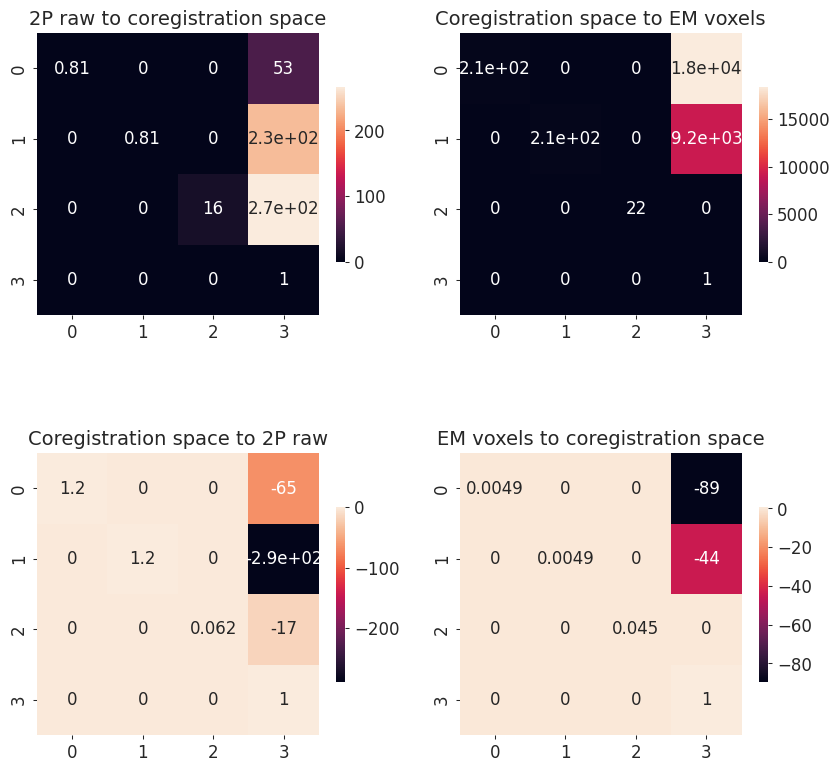

In [7]:
ticklabels = ['x','y','z','bias']
fig, axes = plt.subplots(2,2,figsize=(10,10))

ax = axes[0,0]
sns.heatmap(func_raw2coreg_tform,annot=True,ax=ax,square=True,cbar_kws={'shrink':0.5})
ax.set_title('2P raw to coregistration space')

ax = axes[1,0]
sns.heatmap(func_coreg2raw_tform,annot=True,ax=ax,square=True,cbar_kws={'shrink':0.5})
ax.set_title('Coregistration space to 2P raw')

ax = axes[0,1]
sns.heatmap(em_coreg2final_tform,annot=True,ax=ax,square=True,cbar_kws={'shrink':0.5})
ax.set_title('Coregistration space to EM voxels')

ax = axes[1,1]
sns.heatmap(em_final2coreg_tform,annot=True,ax=ax,square=True,cbar_kws={'shrink':0.5})
ax.set_title('EM voxels to coregistration space')

# for ax in axes:
#     ax.set_xticklabels(ticklabels)
    # ax.set_yticklabels(ticklabels)

In [355]:
# read in test coregistration set
test_set_name_to_final_em_nm_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/combined_noncp_name_to_final_em_nm.json"

with open(test_set_name_to_final_em_nm_fn) as f:
    test_set_name_to_final_em_nm = json.load(f)

test_set_name_to_final_em_nm

{'plane4_roi_0119': [759852.0, 632673.0, 243810.0],
 'plane1_roi_0271': [812700.0, 597132.0, 270405.0],
 'plane1_roi_0262': [918396.0, 607140.0, 236025.0],
 'plane0_roi_0088': [870822.0, 603801.0, 161595.0],
 'plane1_roi_0075': [843354.0, 608688.0, 227655.0],
 'plane3_roi_0089': [841491.0, 654471.0, 186975.0],
 'plane2_roi_0191': [833265.0, 610479.0, 225990.0],
 'plane4_roi_0109': [839862.0, 615132.0, 314550.0],
 'plane0_roi_0040': [782046.0, 575325.0, 261720.0],
 'plane3_roi_0187': [807426.0, 650673.0, 173430.0],
 'plane3_roi_0306': [813087.0, 603333.0, 323145.0],
 'plane2_roi_0215': [790821.0, 597357.0, 278415.0],
 'plane2_roi_0300': [859185.0, 596736.0, 276975.0],
 'plane2_roi_0294': [758070.0, 615213.0, 223065.0],
 'plane3_roi_0325': [758070.0, 615213.0, 223065.0],
 'plane5_roi_0470': [837684.0, 637866.0, 330660.0],
 'plane0_roi_0067': [897750.0, 583938.0, 257715.0],
 'plane2_roi_0032': [815337.0, 626697.0, 172485.0],
 'plane2_roi_0250': [835209.0, 593172.0, 319005.0],
 'plane0_roi

In [361]:
valid_coreg_df.columns
# valid_coreg_df.head()

Index(['ophys_session_id', 'ophys_plane', 'roi_russel', 'roi', 'em_pt_root_id',
       'em_final_em_nm', 'em_final_em_nm_transformed', 'em_coreg',
       'ophys_pos_raw', 'ophys_pos_coreg', 'ophys_pos_coreg_transformed',
       'coreg_disp', 'label', 'flag', 'emx', 'emy', 'emz', 'optx', 'opty',
       'optz', 'type'],
      dtype='object')

In [96]:
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
client = OPhysClient(base_folder)

mouse_id = 409828; col = 1; vol = 3; plane = 3
sess = client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)

testset_chasekeys, plane_list, roi_list = russelROI_to_chaseROI(list(test_set_name_to_final_em_nm.keys()))

#Format into dataframe
test_set_df = pd.DataFrame()

test_set_df.insert(0,"coreg_disp", None)
test_set_df.insert(0,"ophys_pos_coreg_transformed", None)
test_set_df.insert(0,"ophys_pos_coreg", None)
test_set_df.insert(0,"ophys_pos_raw", None)
test_set_df.insert(0,"em_coreg", None)
test_set_df.insert(0,"em_final_em_nm_transformed", None)
test_set_df.insert(0,"em_final_em_nm", list(test_set_name_to_final_em_nm.values()))
test_set_df.insert(0,"em_pt_root_id", None) 

test_set_df.insert(0,"roi", testset_chasekeys)
test_set_df.insert(0,"roi_russel", list(test_set_name_to_final_em_nm.keys()))
test_set_df.insert(0,"ophys_roi", roi_list)
test_set_df.insert(0,"ophys_plane", plane_list)
test_set_df.insert(0,"ophys_session_id", 'M409828_13')

# Load the corresponding 2P positions

test_set_df["emx"] = None
test_set_df["emy"] = None
test_set_df["emz"] = None
test_set_df["optx"] = None
test_set_df["opty"] = None
test_set_df["optz"] = None

for idx, row in test_set_df.iterrows():
    
    session = ophys_client.load_ophys_session(session_id=row.ophys_session_id)
    y, x = np.mean(np.where(session.get_roi_image_mask(plane=row.ophys_plane, roi=row.ophys_roi)), axis=1) # note this is transposed

    #Get points in raw pixel space
    test_set_df.at[idx, "ophys_pos_raw"] = np.array([x, y, row.ophys_plane - 1])

    #Transform points in raw pixel space to coregistration space
    p = transform_pts(func_raw2coreg_tform,np.array([x, y, row.ophys_plane - 1]).reshape(1,-1))[0]
    test_set_df.at[idx, "optx"] = p[0]; test_set_df.at[idx, "opty"] = p[1]; test_set_df.at[idx, "optz"] = p[2]
    test_set_df.at[idx, "ophys_pos_coreg"] = p
    
    #Transform EM nm back into coregistration space
    em_nm = test_set_df.at[idx, "em_final_em_nm"]
    em_voxels = em_nm / em_final_voxel_size
    e = transform_pts(em_final2coreg_tform,em_voxels.reshape(1,-1))[0]
    test_set_df.at[idx, "em_coreg"] = e
    test_set_df.at[idx, "emx"] = e[0]; test_set_df.at[idx, "emy"] = e[1]; test_set_df.at[idx, "emz"] = e[2]
    # print(f'"Test-set-{idx}","false","{e[0]}","{e[1]}","{e[2]}","{p[0]}","{p[1]}","{p[2]}"')

test_set_df

/tmp/ipykernel_1765158/543874617.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_set_df = pd.DataFrame(np.array([list(test_set_name_to_final_em_nm.keys()),testset_chasekeys,list(test_set_name_to_final_em_nm.values())]).T,columns=['roi_russel','roi','em_final_em_nm'])


"Test-set-0","false","670.4569008367179","588.2858884781976","243.81","166.3237376884422","443.9742231155779","331.0"
"Test-set-1","false","723.3049087850582","552.7448831328305","270.405","220.5396793248945","468.175988185654","283.0"
"Test-set-2","false","829.000924681739","562.752884638034","236.02499999999998","335.09812851405627","427.1551277108434","283.0"
"Test-set-3","false","781.4269175266083","559.4138841358482","161.595","295.9163665236051","354.6491836909871","267.0"
"Test-set-4","false","753.9589133954206","564.3008848708531","227.655","261.0742354679803","421.3124660098522","283.0"
"Test-set-5","false","752.0959131152252","610.0838917566173","186.975","262.56758125","378.29845624999996","315.0"
"Test-set-6","false","743.8699118780347","566.0918851402196","225.98999999999998","250.3932769230769","421.24232307692307","299.0"
"Test-set-7","false","750.4669128702237","570.7448858400309","314.55","249.20647699999998","515.272264","331.0"
"Test-set-8","false","692.6509041746959

ophys_session_id  ophys_plane  ophys_roi       roi_russel  \
0        M409828_13            5        119  plane4_roi_0119   
1        M409828_13            2        271  plane1_roi_0271   
2        M409828_13            2        262  plane1_roi_0262   
3        M409828_13            1         88  plane0_roi_0088   
4        M409828_13            2         75  plane1_roi_0075   
5        M409828_13            4         89  plane3_roi_0089   
6        M409828_13            3        191  plane2_roi_0191   
7        M409828_13            5        109  plane4_roi_0109   
8        M409828_13            1         40  plane0_roi_0040   
9        M409828_13            4        187  plane3_roi_0187   
10       M409828_13            4        306  plane3_roi_0306   
11       M409828_13            3        215  plane2_roi_0215   
12       M409828_13            3        300  plane2_roi_0300   
13       M409828_13            3        294  plane2_roi_0294   
14       M409828_13            4        325  plane3_roi_0325   
15       M409828_13            6        470  plane5_roi_0470   
16       M409828_13            1         67  plane0_roi_0067   
17       M409828_13            3         32  plane2_roi_0032   
18       M409828_13            3        250  plane2_roi_0250   
19       M409828_13            1          6  plane0_roi_0006   
20       M409828_13            1         22  plane0_roi_0022   
21       M409828_13            2        170  plane1_roi_0170   

                 roi                                     em_final_em_nm  \
0   M409828_13_5_119                     [759852.0, 632673.0, 243810.0]   
1   M409828_13_2_271                     [812700.0, 597132.0, 270405.0]   
2   M409828_13_2_262                     [918396.0, 607140.0, 236025.0]   
3    M409828_13_1_88                     [870822.0, 603801.0, 161595.0]   
4    M409828_13_2_75                     [843354.0, 608688.0, 227655.0]   
5    M409828_13_4_89                     [841491.0, 654471.0, 186975.0]   
6   M409828_13_3_191                     [833265.0, 610479.0, 225990.0]   
7   M409828_13_5_109                     [839862.0, 615132.0, 314550.0]   
8    M409828_13_1_40                     [782046.0, 575325.0, 261720.0]   
9   M409828_13_4_187                     [807426.0, 650673.0, 173430.0]   
10  M409828_13_4_306                     [813087.0, 603333.0, 323145.0]   
11  M409828_13_3_215                     [790821.0, 597357.0, 278415.0]   
12  M409828_13_3_300                     [859185.0, 596736.0, 276975.0]   
13  M409828_13_3_294                     [758070.0, 615213.0, 223065.0]   
14  M409828_13_4_325                     [758070.0, 615213.0, 223065.0]   
15  M409828_13_6_470                     [837684.0, 637866.0, 330660.0]   
16   M409828_13_1_67                     [897750.0, 583938.0, 257715.0]   
17   M409828_13_3_32                     [815337.0, 626697.0, 172485.0]   
18  M409828_13_3_250                     [835209.0, 593172.0, 319005.0]   
19    M409828_13_1_6  [761231.97734375, 584861.0453125, 207833.57666...   
20   M409828_13_1_22    [865263.7953125, 597459.375, 206643.4716796875]   
21  M409828_13_2_170  [854920.8671874999, 599667.375390625, 241059.6...   

                                             em_coreg  \
0      [670.4569008367179, 588.2858884781976, 243.81]   
1     [723.3049087850582, 552.7448831328305, 270.405]   
2   [829.000924681739, 562.752884638034, 236.02499...   
3     [781.4269175266083, 559.4138841358482, 161.595]   
4     [753.9589133954206, 564.3008848708531, 227.655]   
5     [752.0959131152252, 610.0838917566173, 186.975]   
6   [743.8699118780347, 566.0918851402196, 225.989...   
7      [750.4669128702237, 570.7448858400309, 314.55]   
8   [692.6509041746959, 530.9378798530571, 261.719...   
9       [718.0309079918485, 606.285891185398, 173.43]   
10     [723.6919088432631, 558.945884065461, 323.145]   
11  [701.4259054944562, 552.9698831666705, 278.414...   
12  [769.7899157764033, 552.3488830732721, 276.974...   
13    

In [ ]:
# np.stack(test_set_df['ophys_pos_raw'].values) - test_centers_func_raw
# np.stack(test_set_df['ophys_pos_coreg'].values) - all_roi_func_coreg_pts[test_set_idxs]

np.stack(test_set_df['em_coreg'].values) - all_roi_em_coreg_pts[test_set_idxs]

In [ ]:
duplicates_list = [["M409828_13_1_129", "M409828_13_2_68", "M409828_13_3_10", "M409828_13_4_81", "M409828_13_5_192", "M409828_13_6_179"],
["M409828_13_1_350", "M409828_13_2_131", "M409828_13_3_94", "M409828_13_4_219", "M409828_13_5_367", "M409828_13_6_103"],
["M409828_13_1_52", "M409828_13_2_6", "M409828_13_3_3", "M409828_13_4_12", "M409828_13_5_52", "M409828_13_6_1"],
["M409828_13_1_126", "M409828_13_2_63", "M409828_13_3_27", "M409828_13_4_66", "M409828_13_5_328", "M409828_13_6_112"],
["M409828_13_1_204", "M409828_13_2_79", "M409828_13_3_45", "M409828_13_4_72", "M409828_13_5_276", "M409828_13_6_49"],
["M409828_13_1_225", "M409828_13_2_274", "M409828_13_3_115", "M409828_13_4_181", "M409828_13_5_242", "M409828_13_6_306"]]


base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
client = OPhysClient(base_folder)

mouse_id = 409828; col = 1; vol = 3; plane = 3
sess = client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)

for jj, dupli in enumerate(duplicates_list):
    

    # fig, axes = plt.subplots(1,6,figsize=(24,2))
    # for ax in axes:
    #     ax.axis('off') 
    tmp = np.zeros((6,3)); depths = np.zeros((6,1))
    for ii, d in enumerate(dupli):
        text = d.split('_')
        col = int(text[1][0])
        vol = int(text[1][1])
        plane = int(text[2])
        roi = int(text[3])
        xypixels = sess.get_roi_xy_pixels(plane,roi)

        mask = sess.get_roi_image_mask(plane,roi)
        proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

        yc = np.mean(xypixels[0])
        xc = np.mean(xypixels[1])
        area = np.sum(mask)
        # import pdb; pdb.set_trace()
        fig, axes = plt.subplots(1,2,figsize=(16,8))
        plt.suptitle(f'{d}, plane {plane}',y=0.95)

        ax = axes[0]
        buff = 50
        # ax.imshow(proj_raw_max, cmap='gray', interpolation='nearest')
        ax.imshow(proj_raw_max[slice(int(xc)-buff,int(xc)+buff),slice(int(yc)-buff,int(yc)+buff)], cmap='gray', interpolation='nearest')
        # ax.plot(yc,xc,'xc')
        # ax.vlines(int(yc)-buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')
        # ax.vlines(int(yc)+buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')

        # ax.hlines(int(xc)-buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')
        # ax.hlines(int(xc)+buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')

        ax.set_title(f'max projection, {area} pixel area')

        ax = axes[1]
        # ax.imshow(proj_de_max, cmap='gray', interpolation='nearest')
        ax.imshow(proj_de_max[slice(int(xc)-buff,int(xc)+buff),slice(int(yc)-buff,int(yc)+buff)], cmap='gray', interpolation='nearest')
        # # ax.plot(buff,buff,'Xg')
        # ax.set_title('zoomed in')

        # rois = np.array(sess.get_rois(plane))
        # # indy = sess.is_roi_valid(plane,rois)
        # # mask = sess.get_roi_image_mask(plane,rois[indy])
        # # xypixels = sess.get_roi_xy_pixels(plane,rois[~indy])

        # xstart = int(xc)-50; ystart = int(yc)-50
        
        # for roi in rois:
        #     is_valid = sess.is_roi_valid(plane,roi)
        #     xypixels = sess.get_roi_xy_pixels(plane,roi)
        #     color = 'g' if is_valid else 'r'
        #     x = np.mean(xypixels[1])
        #     y = np.mean(xypixels[0])
            
        #     if (x > xc - 50) & (x < xc + 50) & (y > yc - 50) & (y < yc + 50):
        #         ax.plot(y-ystart,x-xstart,color=color,marker=f'${roi}$',markersize=14)

        # indy = sess.is_roi_valid(plane,rois); 
        # mask = sess.get_roi_image_mask(plane,rois[indy])
        # cell_outlines = return_cell_outlines(mask)
        # ax.imshow(cell_outlines[slice(int(xc)-50,int(xc)+50),slice(int(yc)-50,int(yc)+50)], cmap='brg',vmin=0, interpolation='nearest')

        # mask = sess.get_roi_image_mask(plane,rois[~indy])
        # cell_outlines = return_cell_outlines(mask)
        # ax.imshow(cell_outlines[slice(int(xc)-50,int(xc)+50),slice(int(yc)-50,int(yc)+50)], cmap='bwr',vmin=0, interpolation='nearest')

        depth = depth_dict[(col,vol,plane)]
        tmp[ii,:] = [yc,xc,plane-1]
        depths[ii] = depth

    
    #Transform points in raw pixel space to coregistration space
    points_func_coreg_pts = transform_pts(func_raw2coreg_tform,tmp)

    for ii, d in enumerate(points_func_coreg_pts):
        print(f'"Pt-d{jj}-{ii}","false","0","0","0","{d[0]}","{d[1]}","{d[2]}"')
    # print(points_func_coreg_pts)
    plt.show()
    print('\n')
    pdb.set_trace()
    

blood_vessel_roi = ["M409828_13_1_222", "M409828_13_2_87", "M409828_13_3_567", "M409828_13_4_1260", "M409828_13_5_491", "M409828_13_6_31"]

In [34]:
blood_vessel_roi = ["M409828_13_1_222", "M409828_13_2_87", "M409828_13_3_567", "M409828_13_4_1260", "M409828_13_5_491", "M409828_13_6_31"]

## Interpolate all planes to same time
data_list_interp = sess.interpolate_all_plane_traces_to_common_time_series(trace_type='dff',valid_only=False,reload=True)

#Get number of neurons per plane
nNeurons_plane = [len(t) for t in data_list_interp]
nNeurons_plane
# nNeurons_plane = [1234, 1222, 1482, 1279, 1158, 1148]


[1234, 1222, 1482, 1279, 1158, 1148]

In [59]:
#Get stimulus table
stim_table, stim_meta = sess.get_stimulus_table("natural_images_12")
tStart = stim_table.loc[0,'start']
tEnd = stim_table.loc[479,'end']


<AxesSubplot: >

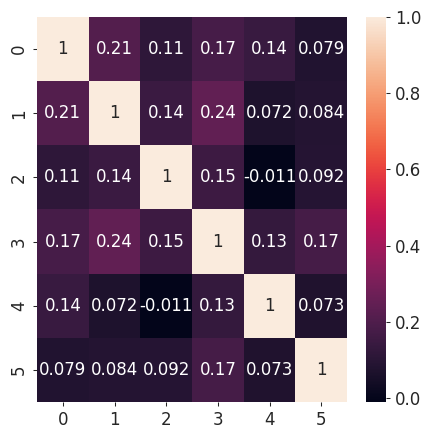

In [47]:
corr_mat = np.zeros((6,6))
for i, t1 in enumerate(trace_list):
    for j, t2 in enumerate(trace_list):
        corr_mat[i,j] = np.corrcoef(t1,t2)[0,1]

sns.heatmap(corr_mat,annot=True)

In [57]:
#Get stimulus table
stim_table, stim_meta = sess.get_stimulus_table("spontaneous")
tStart = stim_table.loc[0,'start']
tEnd = stim_table.loc[0,'end']
tStart
tEnd = tStart + 120


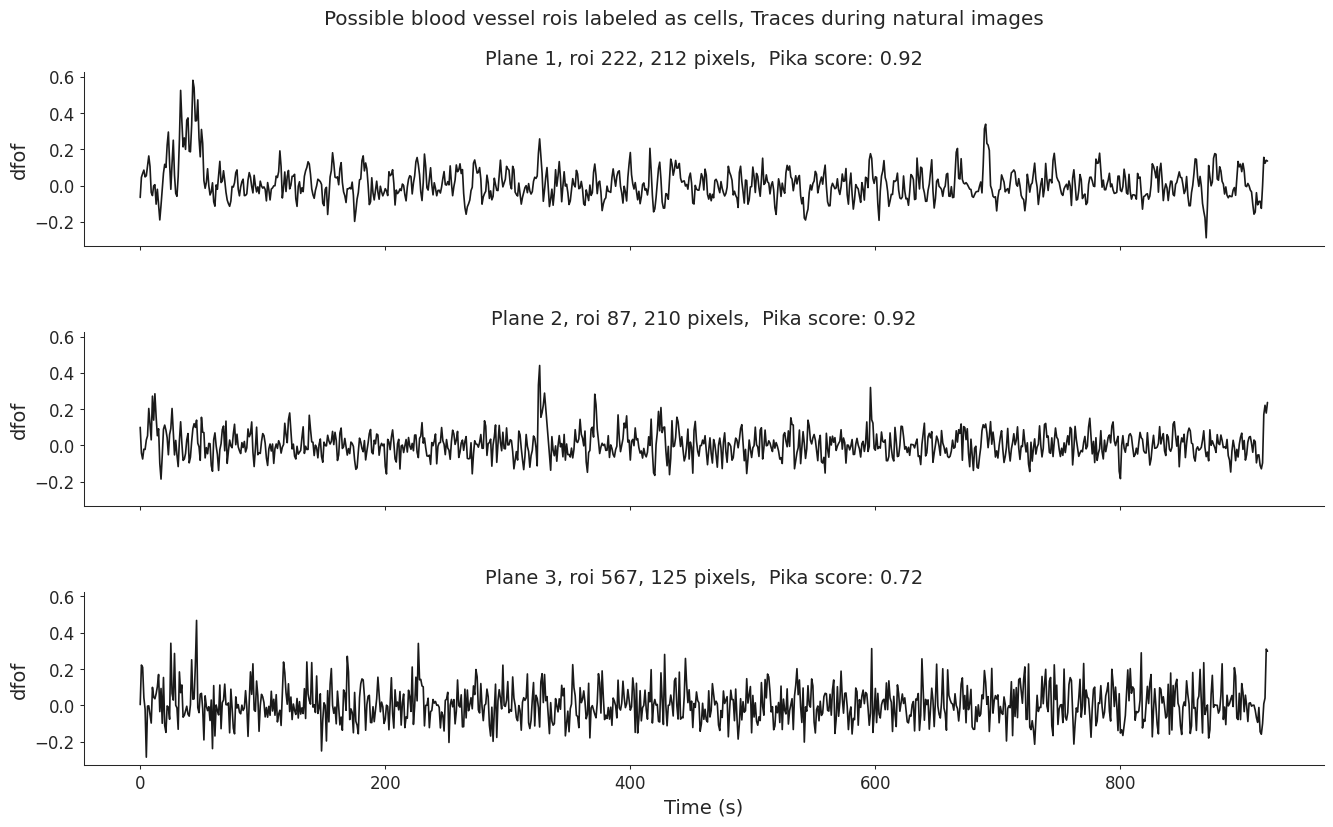

In [60]:
blood_vessel_roi = ["M409828_13_1_222", "M409828_13_2_87", "M409828_13_3_567"]

fig, axes = plt.subplots(3,1,figsize=(16,9),gridspec_kw={'hspace':0.5},sharey=True,sharex=True)
plt.suptitle('Possible blood vessel rois labeled as cells, Traces during natural images',y=0.95)
trace_list = []
for iPlane, roi_id in enumerate(blood_vessel_roi):
    data_xr = data_list_interp[iPlane]
    
    str_split = roi_id.split('_')
    roi = int(str_split[-1])
    plane = int(str_split[-2])
    mask = sess.get_roi_image_mask(plane,roi)
    pika_score = sess.get_pika_roi_confidence(plane, roi)

    trace = data_xr.sel(roi=roi,time=slice(tStart, tEnd))
    trace_list.append(trace)
    ax = axes[iPlane]
    ax.plot(trace,'-k')
    ax.set_ylabel('dfof')
    ax.set_title(f'Plane {plane}, roi {roi}, {np.sum(mask)} pixels,  Pika score: {pika_score:.2f}')

ax.set_xlabel('Time (s)')
plt.savefig(os.path.join(PlotDir,'possible_blood_vessel_rois_NS12.png'))
    


Text(0.5, 0, 'Time (s)')

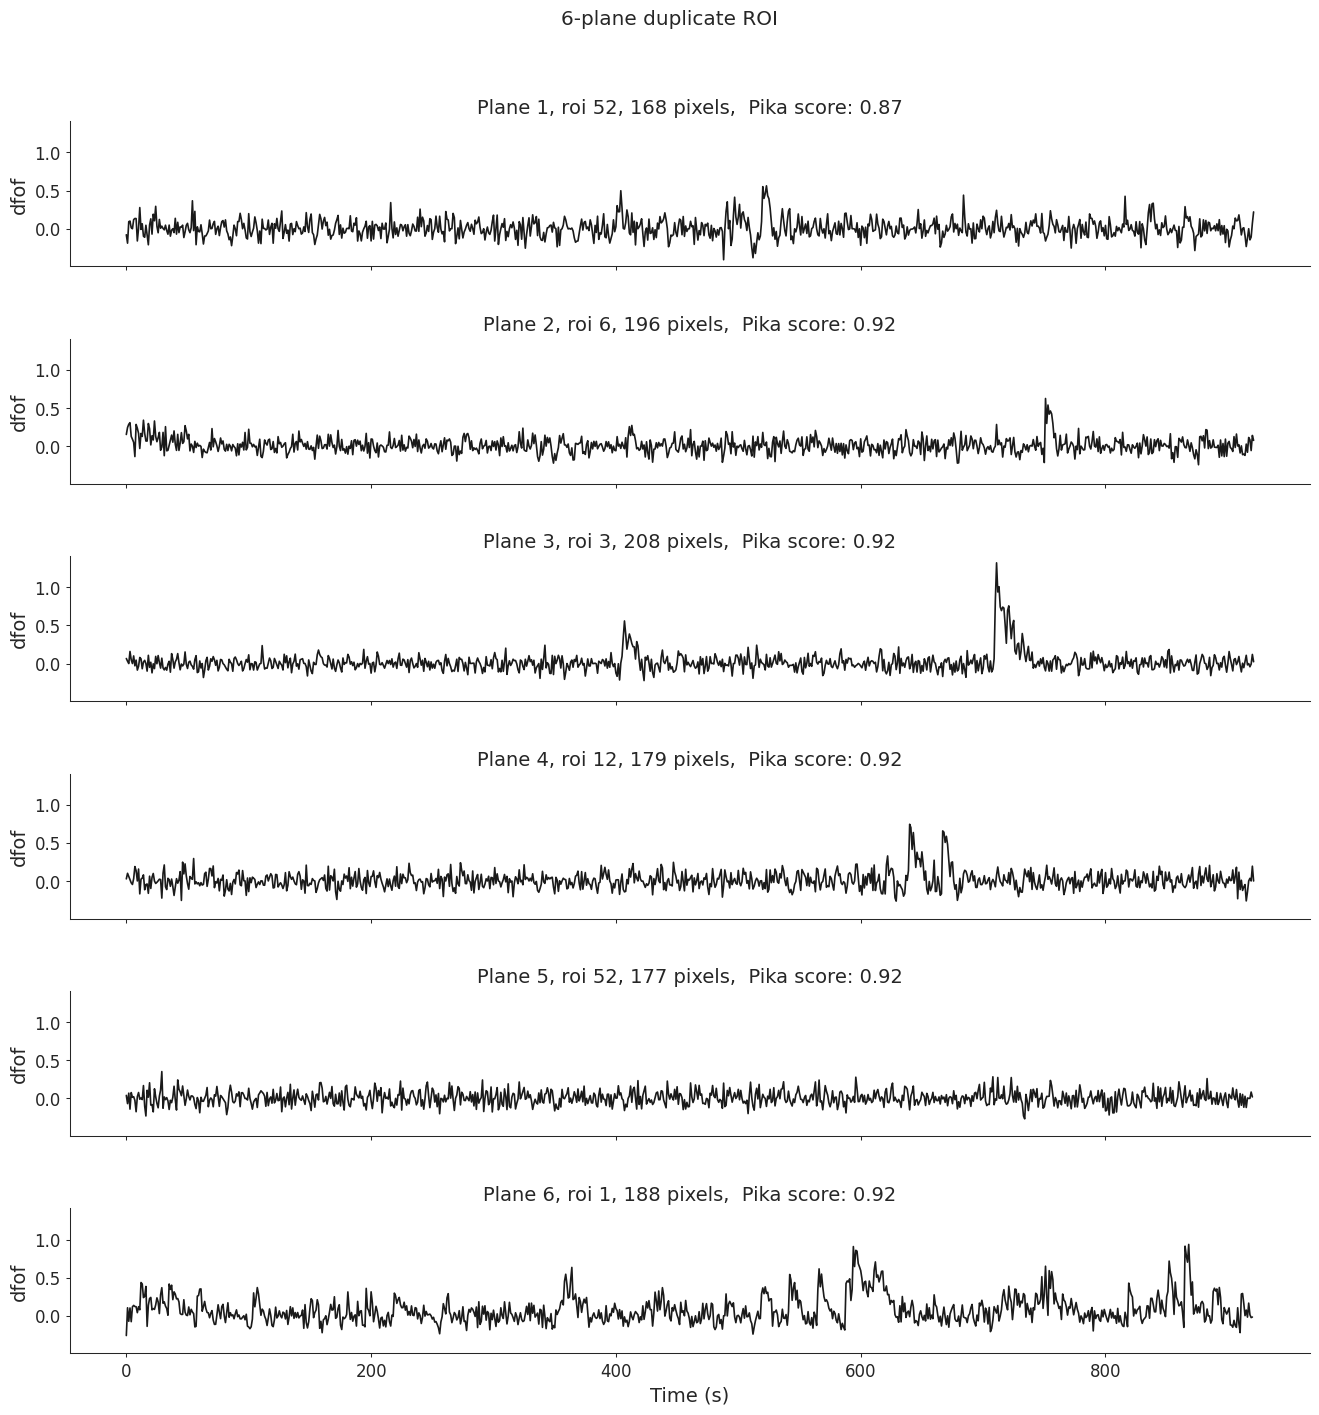

In [70]:

dupli = duplicates_list[2]
fig, axes = plt.subplots(6,1,figsize=(16,16),gridspec_kw={'hspace':0.5},sharey=True,sharex=True)
plt.suptitle('6-plane duplicate ROI',y=0.95)
trace_list = []

for iPlane, roi_id in enumerate(dupli):
    # data_xr = data_list_interp[iPlane]

    data_xr = sess.get_traces(plane,'dff')
    str_split = roi_id.split('_')
    roi = int(str_split[-1])
    plane = int(str_split[-2])
    mask = sess.get_roi_image_mask(plane,roi)
    pika_score = sess.get_pika_roi_confidence(plane, roi)

    trace = data_xr.sel(roi=roi,time=slice(tStart, tEnd))
    trace_list.append(trace)
    ax = axes[iPlane]
    ax.plot(trace,'-k')
    ax.set_ylabel('dfof')
    ax.set_title(f'Plane {plane}, roi {roi}, {np.sum(mask)} pixels,  Pika score: {pika_score:.2f}')

ax.set_xlabel('Time (s)')
# plt.savefig(os.path.join(PlotDir,'possible_blood_vessel_rois_NS12.png'))
    


<AxesSubplot: >

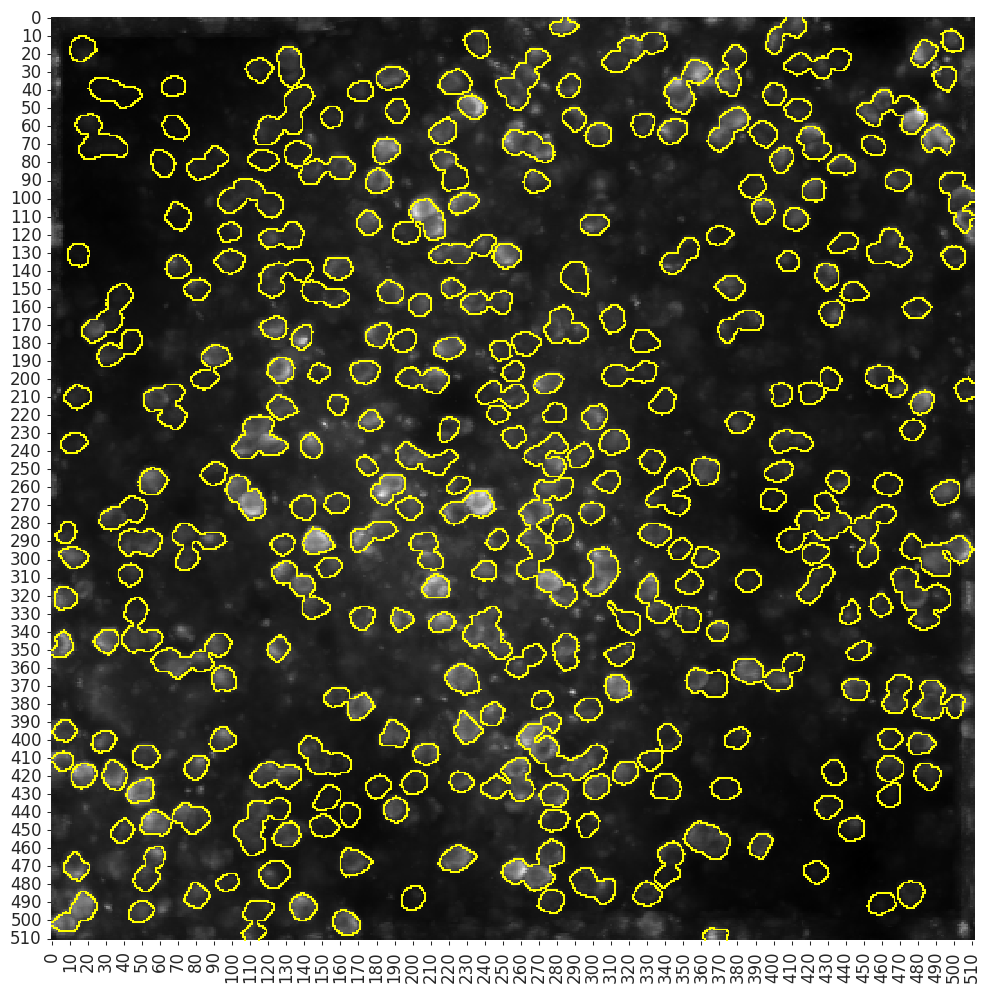

In [27]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import sobel

# read in the binary mask
img = np.array(mask,dtype=int)

def return_cell_outlines(binary_image):
       img = np.array(binary_image,dtype=int)
       # define Sobel filter kernels for edge detection in x and y directions
       sobel_x_kernel = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]])

       sobel_y_kernel = np.array([[-1, -2, -1],
                            [0, 0, 0],
                            [1, 2, 1]])

       # apply Sobel filter to detect edges in x and y directions
       sobel_x = convolve2d(img, sobel_x_kernel, mode='same', boundary='symm')
       sobel_y = convolve2d(img, sobel_y_kernel, mode='same', boundary='symm')

       # combine Sobel x and y filters to get edge magnitude
       edge_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

       # threshold the edge detection output
       threshold = 1
       edge_mag[edge_mag < threshold] = 0
       edge_mag[edge_mag >= threshold] = 1
       edges = np.abs(edge_mag - 1)

       #find cell outlines
       tmp = img - edges
       edge_mask = tmp > 0
       cell_outlines = np.zeros(edge_mask.shape)*np.nan
       cell_outlines[edge_mask] = 1

       return cell_outlines

cell_outlines = return_cell_outlines(mask)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(proj_de_max, cmap='gray', interpolation='nearest')
sns.heatmap(cell_outlines,cbar=False,cmap='spring',vmin=0,ax=ax)

## build coregistration transform

In [362]:
em_final_voxel_size = np.array([4.85, 4.85, 45])

# get landmarks from file used as input
# landmark_file = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/manual_coregistration/20230317_V1_C3_V1DD/landmarks_EM_to_2pStruct+Funct3chan_vol_13_202303017_V5.csv"
landmark_file = "/home/david.wyrick/Desktop/landmarks_EM_to_2pStruct+Funct3chan_vol_13_202303017_V5_withtypes.csv"
landmark_headers = ['label', 'flag', 'emx', 'emy', 'emz', 'optx', 'opty', 'optz','type']

coreg_df = pd.read_csv(
    landmark_file,
    header=None,
    names=landmark_headers
)

valid_coreg_df = coreg_df[coreg_df.flag]
cell_mask = np.array(valid_coreg_df.type == 'Cell')
em_coreg_pts = np.array(valid_coreg_df[["emx", "emy", "emz"]])
func_coreg_pts = np.array(valid_coreg_df[["optx", "opty", "optz"]])

valid_coreg_df = valid_coreg_df.astype({'label':str, 'flag':bool, 'emx':float, 'emy':float, 'emz':float, 'optx':float, 'opty':float, 'optz':float,'type':str})


In [215]:
## Q: Are all of these transformations being fit and applied successively? I think so
transform_list = [
    {
        "name": "PolynomialModel",
        "order": 1,
        "regularization": [0, 0, 0, 0]
    },
    {
        "name": "ChunkedModel",
        "order": 1,
        "nchunks": 3,
        "axis": 0
    },
    {
        "name": "SplineModel",
        "ncntrl": [3, 3, 3],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [5, 5, 5],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e8]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6] # originally last was 1e8
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e9]
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]  # originally last was 1e9
    },
    {
        "name": "SplineModel",
        "voronoi_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 5e4]
    },
        
]

transform_obj = {
        "name": "TransformList",
        "transforms": transform_list
    }

# estimate transformation
tform = coregister.transform.Transform(json=transform_obj)
tform.estimate(func_coreg_pts, em_coreg_pts)


In [363]:
from glob import glob

## Get all 2P cells 
all_roi_info = []; volume_list = []
for vol in range(1,10):
    nwb_file = glob(f'/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data/nwbs/processed/M409828_1{vol}_*.nwb')[0]

    with ROI_mask_nwb(nwb_file, vol=vol, mode="r") as rmn:
        tmp = [*rmn.yield_roi_info()]
        all_roi_info.extend(tmp)


In [364]:
#Vol 3, plane 1 is "0" in raw pixel space
#Vol 3, plane 6 is "5" in raw pixel space

counter = 0

depth_raw = {}
for vol in range(1,10):

    if vol <= 5:
        planemax = 7
    else:
        planemax = 2

    for plane in range(1,planemax):
        print(f'{vol}_{plane}: {counter-12}')
        depth_raw[(vol,plane)] = counter-12
        counter += 1

1_1: -12
1_2: -11
1_3: -10
1_4: -9
1_5: -8
1_6: -7
2_1: -6
2_2: -5
2_3: -4
2_4: -3
2_5: -2
2_6: -1
3_1: 0
3_2: 1
3_3: 2
3_4: 3
3_5: 4
3_6: 5
4_1: 6
4_2: 7
4_3: 8
4_4: 9
4_5: 10
4_6: 11
5_1: 12
5_2: 13
5_3: 14
5_4: 15
5_5: 16
5_6: 17
6_1: 18
7_1: 19
8_1: 20
9_1: 21


In [365]:
# Get 2p ROI center of mass in xy plane, disregarding depth for now
all_roi_raw_center_pts = np.array([center_from_pix_mask(roi.pix_mask).tolist() + [depth_raw[(roi.volume,roi.plane_z+1)]] for roi in all_roi_info])

#Transform points in raw pixel space to coregistration space
all_roi_func_coreg_pts = transform_pts(func_raw2coreg_tform,all_roi_raw_center_pts)

# Get names
all_roi_names = np.array([roi.name for roi in all_roi_info])
all_roi_chasenames = np.array([roi.chase_ROI for roi in all_roi_info])

#Transform 2p functional locations to EM using transform created using all co-registered cells
all_roi_em_coreg_pts = tform.tform(all_roi_func_coreg_pts)

# Transform coregistered points back into EM space 
all_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, all_roi_em_coreg_pts)
all_roi_em_final_pts_nms = all_roi_em_final_pts_voxels * em_final_voxel_size

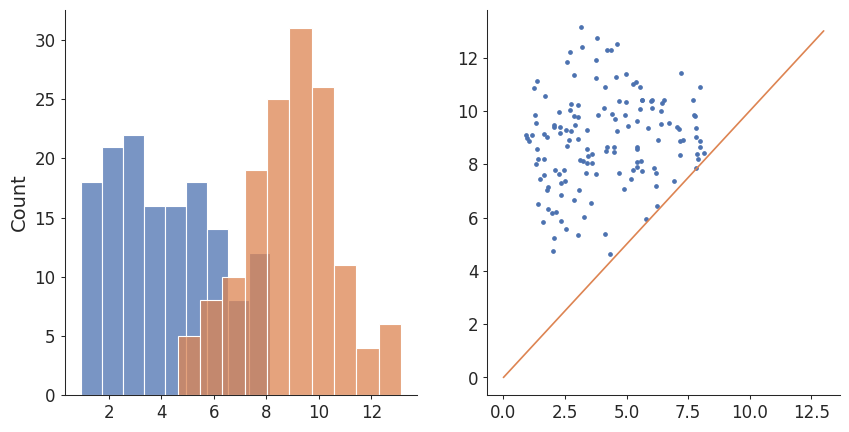

In [222]:
## These points in valid_coreg_df are going to be used to create the transform; the EM and 2P locations are in the format extracted by bigwarp.
## So, we don't know the cell IDs of these cells. In part because some of these points are not cells, but vasculature and other control points
## What I'm going to do is to try and use the given locations and match them to what is calculate in the EM nucleus detecton table
## and the 2P mask and plane depth. Both data are in the "co-registration space" in microns

# Let's first start with the functional data
kdt = scipy.spatial.KDTree(all_roi_func_coreg_pts)
distances, indices = kdt.query(func_coreg_pts[cell_mask], k=2)

fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.histplot(distances[:,0],ax=axes[0])
sns.histplot(distances[:,1],ax=axes[0])

ax = axes[1]
ax.plot(distances[:,0],distances[:,1],'.')
ax.plot([0,13],[0,13])


In [366]:
valid_coreg_df.insert(0,"coreg_disp", None)
valid_coreg_df.insert(0,"ophys_pos_coreg_transformed", None)
valid_coreg_df.insert(0,"ophys_pos_coreg", None)
valid_coreg_df.insert(0,"ophys_pos_raw", None)
valid_coreg_df.insert(0,"em_coreg", None)
valid_coreg_df.insert(0,"em_final_em_nm_transformed", None)
valid_coreg_df.insert(0,"em_final_em_nm", None)
valid_coreg_df.insert(0,"em_pt_root_id", None)
valid_coreg_df.insert(0,"roi", None)
valid_coreg_df.insert(0,"roi_russel", None)
valid_coreg_df.insert(0,"ophys_plane", None)
valid_coreg_df.insert(0,"ophys_session_id", 'M409828_13')

valid_coreg_df

ophys_session_id ophys_plane roi_russel   roi em_pt_root_id  \
0         M409828_13        None       None  None          None   
1         M409828_13        None       None  None          None   
2         M409828_13        None       None  None          None   
3         M409828_13        None       None  None          None   
4         M409828_13        None       None  None          None   
..               ...         ...        ...   ...           ...   
166       M409828_13        None       None  None          None   
167       M409828_13        None       None  None          None   
168       M409828_13        None       None  None          None   
169       M409828_13        None       None  None          None   
170       M409828_13        None       None  None          None   

    em_final_em_nm em_final_em_nm_transformed em_coreg ophys_pos_raw  \
0             None                       None     None          None   
1             None                       None     None          None   
2             None                       None     None          None   
3             None                       None     None          None   
4             None                       None     None          None   
..             ...                        ...      ...           ...   
166           None                       None     None          None   
167           None                       None     None          None   
168           None                       None     None          None   
169           None                       None     None          None   
170           None                       None     None          None   

    ophys_pos_coreg  ... coreg_disp   label  flag         emx         emy  \
0              None  ...       None    Pt-0  True  635.280344  328.978703   
1              None  ...       None    Pt-1  True  698.750236  322.681404   
2              None  ...       None    Pt-2  True  708.255653  330.192179   
3              None  ...       None    Pt-3  True  903.305203  379.623403   
4              None  ...       None    Pt-4  True  637.073622  448.602289   
..              ...  ...        ...     ...   ...         ...         ...   
166            None  ...       None  Pt-167  True  657.726865  541.792011   
167            None  ...       None  Pt-168  True  664.090085  534.638135   
168            None  ...       None  Pt-169  True  637.441519  526.550801   
169            None  ...       None  Pt-170  True  675.456796  522.787312   
170            None  ...       None  Pt-171  True  668.523972  515.931438   

            emz        optx        opty        optz          type  
0    226.841928  119.337257  469.505399   75.311303  Blood-vessel  
1    275.377240  163.517246  516.582437   75.009528  Blood-vessel  
2    355.508033  176.817332  600.794368   93.116080  Blood-vessel  
3    346.601671  381.113136  563.926411  130.782925  Blood-vessel  
4    212.665276  140.822510  434.169473  181.844683  Blood-vessel  
..          ...         ...         ...         ...           ...  
166  389.449195  141.067111  600.960586  327.332998          Cell  
167  409.200705  146.879157  621.033032  326.281045          Cell  
168  423.039181  117.657481  636.143693  323.096453          Cell  
169  423.113680  161.177480  633.418759  318.343023          Cell  
170  409.212039  151.607164  620.843496  319.002065          Cell  

[165 rows x 21 columns]

In [368]:
cell_info.volume

3

In [370]:
choose_2nd_cell = ['Pt-40','Pt-65 0574','Pt-84 2_0074', 'Pt-116 4_0419 basal','Pt-118','Pt-126']
vol_list = []
for idx, row in valid_coreg_df.iterrows():

    #Get ophys coreg values
    ophys_pos_coreg = np.array([row.optx,row.opty,row.optz])

    #Get em coreg values
    em_pos_coreg = np.array([row.emx,row.emy,row.emz])

    valid_coreg_df.at[idx,'ophys_pos_coreg'] = ophys_pos_coreg
    valid_coreg_df.at[idx,'em_coreg'] = em_pos_coreg

    if (row.flag == False) | (row.type != 'Cell'):
        continue
        
    #Transform points from coregistration space to raw pixel space
    ophys_pos_raw = transform_pts(func_coreg2raw_tform,ophys_pos_coreg.reshape(1,-1))

    #Search tree
    kdt = scipy.spatial.KDTree(all_roi_func_coreg_pts)
    distances, indices = kdt.query(ophys_pos_coreg, k=2)

    #Get index
    if row.label in choose_2nd_cell:
        indy = indices[1]
    else:
        indy = indices[0]
    cell_info = all_roi_info[indy]
    # cell_info2 = all_roi_info[indices[1]]
    # print(f'{row.label:15s}: {cell_info.chase_ROI:25s} -> {cell_info.pika_score:.2f} \t {cell_info2.chase_ROI:25s} -> {cell_info2.pika_score:.2f}')
    vol_list.append(cell_info.volume)
    #Populate cell info
    valid_coreg_df.at[idx,'ophys_pos_coreg_transformed'] = all_roi_func_coreg_pts[indy]
    valid_coreg_df.at[idx,'ophys_plane'] = cell_info.plane_z + 1
    valid_coreg_df.at[idx,'roi_russel'] = cell_info.name
    valid_coreg_df.at[idx,'roi'] = cell_info.chase_ROI
    valid_coreg_df.at[idx,'ophys_pos_raw'] = all_roi_raw_center_pts[indy]
    valid_coreg_df.at[idx,'em_final_em_nm_transformed'] = all_roi_em_final_pts_nms[indy]
    valid_coreg_df.at[idx,'coreg_disp'] = np.linalg.norm(all_roi_func_coreg_pts[indy] - ophys_pos_coreg) #

    # print(f'"{row.label}","true","{em_pos_coreg[0]}","{em_pos_coreg[1]}","{em_pos_coreg[2]}","{ophys_pos_coreg[0]}","{ophys_pos_coreg[1]}","{ophys_pos_coreg[2]}"')
    # pts = np.squeeze(all_roi_func_coreg_pts[indices])
    # c = 0
    # for p in pts:
    #     print(f'"{idx}-m-{c}","false","{em_pos_coreg[0]}","{em_pos_coreg[1]}","{em_pos_coreg[2]}","{p[0]}","{p[1]}","{p[2]}"')
    #     c += 1
    # pdb.set_trace()
valid_coreg_df


ophys_session_id ophys_plane       roi_russel               roi  \
0         M409828_13        None             None              None   
1         M409828_13        None             None              None   
2         M409828_13        None             None              None   
3         M409828_13        None             None              None   
4         M409828_13        None             None              None   
..               ...         ...              ...               ...   
166       M409828_13           5  plane4_roi_0328  M409828_13_5_328   
167       M409828_13           5  plane4_roi_0086   M409828_13_5_86   
168       M409828_13           5  plane4_roi_0098   M409828_13_5_98   
169       M409828_13           4  plane3_roi_0148  M409828_13_4_148   
170       M409828_13           4  plane3_roi_0053   M409828_13_4_53   

    em_pt_root_id em_final_em_nm  \
0            None           None   
1            None           None   
2            None           None   
3            None           None   
4            None           None   
..            ...            ...   
166          None           None   
167          None           None   
168          None           None   
169          None           None   
170          None           None   

                            em_final_em_nm_transformed  \
0                                                 None   
1                                                 None   
2                                                 None   
3                                                 None   
4                                                 None   
..                                                 ...   
166  [746709.6654147074, 586261.6329720531, 389822....   
167  [751940.4657158236, 580347.6383377162, 408433....   
168  [724832.3204928233, 577474.4948228847, 423202....   
169  [765802.2545104929, 562926.5705324467, 420983....   
170  [759502.426517531, 567421.5159383188, 405614.5...   

                                              em_coreg  \
0               [635.2803438, 328.9787035, 226.841928]   
1              [698.7502361, 322.6814042, 275.3772396]   
2              [708.2556528, 330.1921791, 355.5080331]   
3              [903.3052035, 379.6234028, 346.6016709]   
4                [637.073622, 448.602289, 212.6652757]   
..                                                 ...   
166  [657.726864763373, 541.792011185292, 389.44919...   
167  [664.090084671168, 534.638134848571, 409.20070...   
168  [637.44151905147, 526.550800952413, 423.039180...   
169  [675.456795940076, 522.787312219159, 423.11368...   
170  [668.523972253114, 515.931438032907, 409.21203...   

                                     ophys_pos_raw  \
0                                             None   
1                                             None   
2                                             None   
3                                             None   
4                                             None   
..                                             ...   
166   [108.40235356262893, 453.9216935525802, 4.0]   
167    [115.31625772340486, 477.612354813617, 4.0]   
168   [80.20000653212274, 498.87306228907147, 4.0]   
169  [134.23362693820044, 492.92772708604946, 3.0]   
170   [125.21005222320822, 473.5014053610326, 3.0]   

                                       ophys_pos_coreg  ... coreg_disp  \
0               [119.337257, 469.5053993, 75.31130338]  ...       None   
1               [163.5172461, 516.5824369, 75.0095275]  ...       None   
2              [176.8173322, 600.7943684, 93.11608041]  ...       None   
3               [381.113136, 563.9264112, 130.7829247]  ...       None   
4              [140.8225102, 434.1694733, 181.8446827]  ...       None   
..                                                 ...  ...        ...   
166  [141.067110956685, 600.960585983387, 327.33299...  ...   3.772396   
167  [146.879156923195, 621.033031943355, 326.28104...  ...    4.97476   
168  [117

In [225]:
for idx, row in valid_coreg_df.iterrows():
    if (row.flag == False) | (row.type != 'Cell'):
        continue

    print(row.label,row.coreg_disp)

Pt-9 0_0117 [-0.53730573 -2.744996    5.3571549 ]
Pt-10 [ 0.36543268 -1.6699682  -1.5321614 ]
Pt-11 [-0.28797056 -2.16588023 -5.6280244 ]
Pt-12 [-0.95905838 -1.81962535 -5.6280244 ]
Pt-13 [-0.24553609 -1.23628595 -0.1668738 ]
Pt-14 [-0.16193095 -1.39651797  0.1299248 ]
Pt-15 [ 1.07956984 -1.45988214 -2.4389728 ]
Pt-16 [ 0.06570053 -0.51548558 -3.1368072 ]
Pt-17 [-0.80435514  0.49905385 -4.4940909 ]
Pt-18 1_0005 [ 0.17095674 -1.36191256 -4.4940909 ]
Pt-19 [-0.17017628  0.29416261  1.660474  ]
Pt-20 [-0.48278538 -0.45768469  5.5925572 ]
Pt-21 1_0026 [ 0.12983436  0.23067432 -0.903928  ]
Pt-22 [-0.98549778  0.17431955 -2.3659038 ]
Pt-23 [ 0.88353473  0.90276056 -5.1012659 ]
Pt-24 [ 0.05475596 -0.42520398 -3.3916646 ]
Pt-25 2_0265 [-1.26355794 -0.93042767  2.4074817 ]
Pt-26 [-1.03126922 -0.89849669  0.0762071 ]
Pt-27 [-0.21314867 -0.83327828 -1.1170051 ]
Pt-28 [-1.24807845  0.28253292  5.2551454 ]
Pt-29 [-1.48247579 -2.52839247  1.3939442 ]
Pt-30 [ 2.38394898 -0.27394113  5.2551454 ]
Pt-31

False


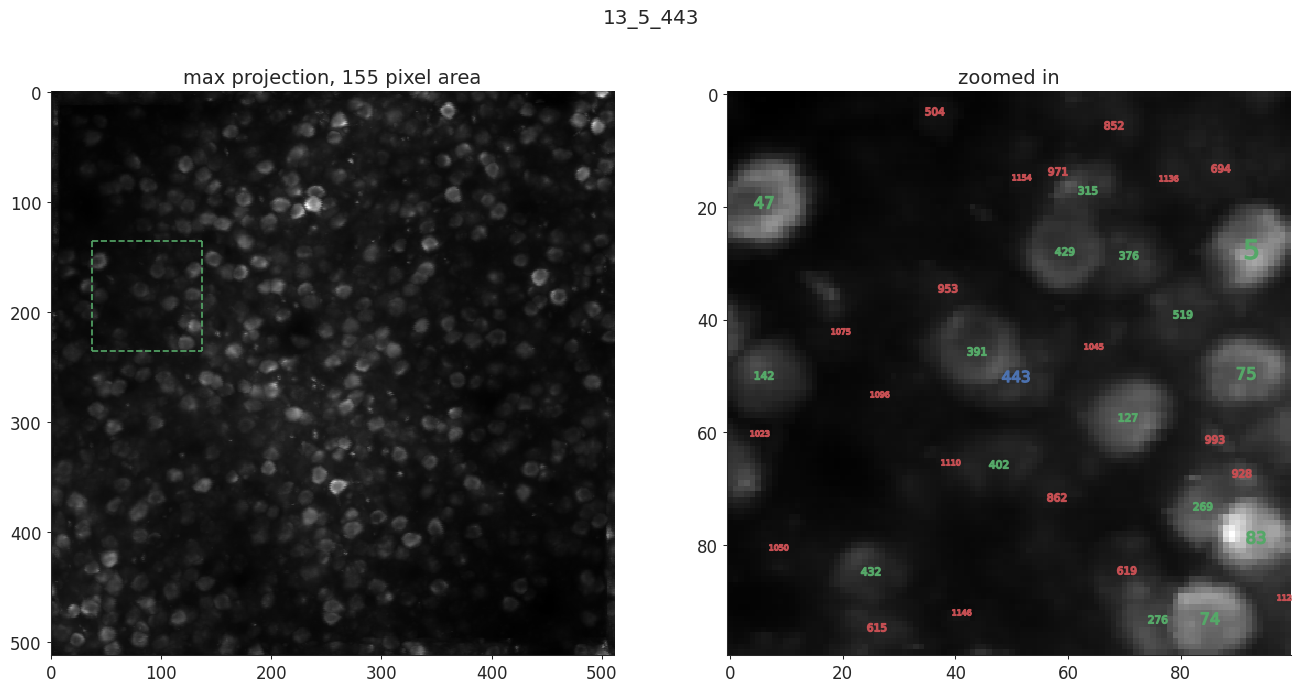

In [249]:
col = 1
vol = 3
plane = 5
center_roi = 443
xypixels = sess.get_roi_xy_pixels(plane,center_roi)

mask = sess.get_roi_image_mask(plane,center_roi)
proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

yc = np.mean(xypixels[0])
xc = np.mean(xypixels[1])
area = np.sum(mask)
# import pdb; pdb.set_trace()
fig, axes = plt.subplots(1,2,figsize=(16,8))
plt.suptitle(f'{col}{vol}_{plane}_{center_roi}',y=0.95)

ax = axes[0]
buff = 50
ax.imshow(proj_de_max, cmap='gray', interpolation='nearest')
# ax.plot(yc,xc,'xc')
ax.vlines(int(yc)-buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')
ax.vlines(int(yc)+buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')

ax.hlines(int(xc)-buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')
ax.hlines(int(xc)+buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')

ax.set_title(f'max projection, {area} pixel area')

ax = axes[1]
ax.imshow(proj_de_max[slice(int(xc)-buff,int(xc)+buff),slice(int(yc)-buff,int(yc)+buff)], cmap='gray', interpolation='nearest')
# ax.plot(buff,buff,'Xg')
ax.set_title('zoomed in')

rois = np.array(sess.get_rois(plane))
# indy = sess.is_roi_valid(plane,rois)
# mask = sess.get_roi_image_mask(plane,rois[indy])
# xypixels = sess.get_roi_xy_pixels(plane,rois[~indy])

xstart = int(xc)-50; ystart = int(yc)-50

for roi in rois:
    is_valid = sess.is_roi_valid(plane,roi)
    xypixels = sess.get_roi_xy_pixels(plane,roi)
    color = 'g' if is_valid else 'r'
    x = np.mean(xypixels[1])
    y = np.mean(xypixels[0])
    
    if (x > xc - 50) & (x < xc + 50) & (y > yc - 50) & (y < yc + 50):
        if roi == center_roi:
            print(is_valid)
            ax.plot(y-ystart,x-xstart,color='b',marker=f'${roi}$',markersize=20)
        else:
            ax.plot(y-ystart,x-xstart,color=color,marker=f'${roi}$',markersize=14)

True


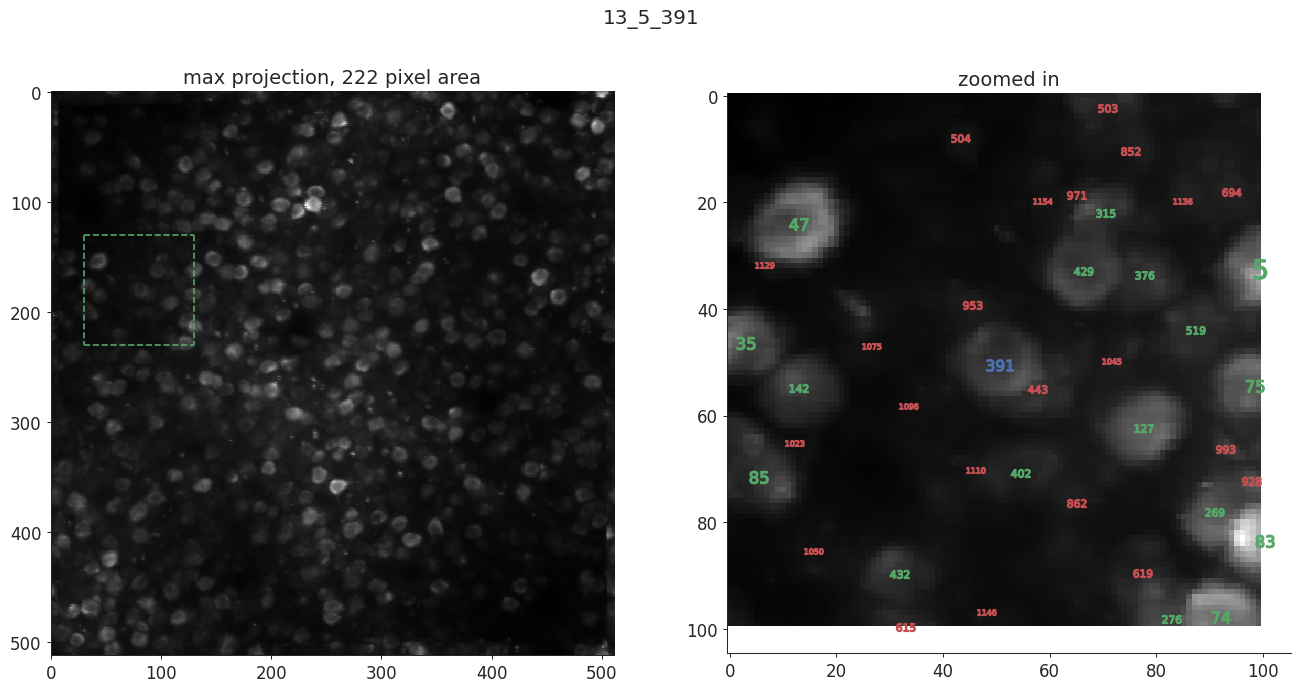

In [250]:
col = 1
vol = 3
plane = 5
center_roi = 391
xypixels = sess.get_roi_xy_pixels(plane,center_roi)

mask = sess.get_roi_image_mask(plane,center_roi)
proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

yc = np.mean(xypixels[0])
xc = np.mean(xypixels[1])
area = np.sum(mask)
# import pdb; pdb.set_trace()
fig, axes = plt.subplots(1,2,figsize=(16,8))
plt.suptitle(f'{col}{vol}_{plane}_{center_roi}',y=0.95)

ax = axes[0]
buff = 50
ax.imshow(proj_de_max, cmap='gray', interpolation='nearest')
# ax.plot(yc,xc,'xc')
ax.vlines(int(yc)-buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')
ax.vlines(int(yc)+buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')

ax.hlines(int(xc)-buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')
ax.hlines(int(xc)+buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')

ax.set_title(f'max projection, {area} pixel area')

ax = axes[1]
ax.imshow(proj_de_max[slice(int(xc)-buff,int(xc)+buff),slice(int(yc)-buff,int(yc)+buff)], cmap='gray', interpolation='nearest')
# ax.plot(buff,buff,'Xg')
ax.set_title('zoomed in')

rois = np.array(sess.get_rois(plane))
# indy = sess.is_roi_valid(plane,rois)
# mask = sess.get_roi_image_mask(plane,rois[indy])
# xypixels = sess.get_roi_xy_pixels(plane,rois[~indy])

xstart = int(xc)-50; ystart = int(yc)-50

for roi in rois:
    is_valid = sess.is_roi_valid(plane,roi)
    xypixels = sess.get_roi_xy_pixels(plane,roi)
    color = 'g' if is_valid else 'r'
    x = np.mean(xypixels[1])
    y = np.mean(xypixels[0])
    
    if (x > xc - 50) & (x < xc + 50) & (y > yc - 50) & (y < yc + 50):
        if roi == center_roi:
            print(is_valid)
            ax.plot(y-ystart,x-xstart,color='b',marker=f'${roi}$',markersize=20)
        else:
            ax.plot(y-ystart,x-xstart,color=color,marker=f'${roi}$',markersize=14)

In [309]:
#Find the corresponding em nucleus location
cave_client = caveclient.CAVEclient('v1dd')

#Get all cells in EM volume 
res = cave_client.materialize.query_table("nucleus_detection_v0")
res.shape

(207455, 10)

In [350]:
idx = 5
print((res.at[idx,'pt_position']	- res.at[idx,'bb_start_position'])/1000)
print((res.at[idx,'pt_position']	- res.at[idx,'bb_end_position'])/1000)
print((res.at[idx,'bb_start_position'] - res.at[idx,'bb_end_position'])/1000)

[  4.966   5.432 686.001]
[ -5.432  -5.898 684.614]
[-10.398 -11.33   -1.387]


In [351]:
res.at[idx,'pt_position']

array([1640231,  677370,  768015])

In [352]:
res.at[idx,'bb_start_position']

array([1635265,  671938,   82014])

In [310]:
#Extract point position 
nucleus_pts = np.array([i for i in res.pt_position])
nucleus_ids = np.array([i for i in res.pt_root_id])

# Match cells used for creating co-registration transform to nucleus location 
kdt = scipy.spatial.KDTree(nucleus_pts)



In [311]:
nucleus_pts_coreg = transform_pts(em_final2coreg_tform, nucleus_pts/em_final_voxel_size)
kdt2 = scipy.spatial.KDTree(nucleus_pts_coreg)

In [ ]:
#Transform points used for creating transform into em space
corr_pts_em_voxels = transform_pts(em_coreg2final_tform, em_coreg_pts)
corr_pts_em_nm = corr_pts_em_voxels * em_final_voxel_size



distances, indices = kdt.query(all_roi_em_final_pts_nms, k=2)
rod = distances[:, 0] / distances[:, 1]
predicted_nucleus_pts_centroids = nucleus_pts[indices[:, 0]]

In [331]:
for idx, row in valid_coreg_df.iterrows():

    #Get ophys coreg values
    ophys_pos_coreg = np.array([row.optx,row.opty,row.optz])

    #Get em coreg values
    em_pos_coreg = np.array([row.emx,row.emy,row.emz])

    if (row.flag == False) | (row.type != 'Cell'):
        continue

    #Transform points used for creating transform into em space
    corr_pts_em_voxels = transform_pts(em_coreg2final_tform, em_pos_coreg.reshape(1,-1))
    corr_pts_em_nm = corr_pts_em_voxels * em_final_voxel_size

    # pix2em = valid_coreg_df.at[idx,'em_final_em_nm_transformed']
    # tmp = np.linalg.norm(corr_pts_em_nm - pix2em)/1000

    # #Transform 2p-coreg into EM coreg
    # em_pos_coreg2 = tform.tform(ophys_pos_coreg.reshape(1,-1))
    
    #Match to nucleus ID
    distances, indices = kdt2.query(em_pos_coreg, k=2)

    valid_coreg_df.at[idx,'em_pt_root_id'] = nucleus_ids[indices[0]]
    valid_coreg_df.at[idx,'em_final_em_nm'] = nucleus_pts[indices[0]]

    # distances2, indices2 = kdt.query(corr_pts_em_nm, k=2)
    # print(f'{row.label:20s}: {distances[0]:.2f}, {distances2[0,0]/1000:.2f}')
    # print(f'"{row.label}","true","{em_pos_coreg[0]}","{em_pos_coreg[1]}","{em_pos_coreg[2]}","{ophys_pos_coreg[0]}","{ophys_pos_coreg[1]}","{ophys_pos_coreg[2]}"')
    # pts = np.squeeze(nucleus_pts_coreg[indices])
    # c = 0
    # for p in pts:
    #     print(f'"{row.label}-m-{c}","false","{p[0]}","{p[1]}","{p[2]}","{ophys_pos_coreg[0]}","{ophys_pos_coreg[1]}","{ophys_pos_coreg[2]}"')
    #     c += 1
    # pdb.set_trace()


    # if indices[0,0]==indices2[0]:
        
        # pass
        # valid_coreg_df.at[idx,'em_pt_root_id'] = nucleus_ids[indices2[0]]
        # valid_coreg_df.at[idx,'em_final_em_nm'] = nucleus_pts[indices2[0]]
    # if indices[0]!=indices2[0,0]:
    #     print(f'{row.label:20s}: {tmp:.2f}, {indices[0]}, {indices2}')


In [336]:
valid_coreg_df
em_coreg_pts_train = np.array(valid_coreg_df[["emx", "emy", "emz"]])
func_coreg_pts_train = np.array(valid_coreg_df[["optx", "opty", "optz"]])

In [334]:
test_set_df
em_coreg_pts_test = np.array(test_set_df[["emx", "emy", "emz"]])
func_coreg_pts_test = np.array(test_set_df[["optx", "opty", "optz"]])

In [344]:
func_coreg_pts = np.vstack((func_coreg_pts_train,func_coreg_pts_test))
func_coreg_pts = np.array(func_coreg_pts,dtype=float)
em_coreg_pts = np.vstack((em_coreg_pts_train,em_coreg_pts_test))
em_coreg_pts = np.array(em_coreg_pts,dtype=float)

In [345]:
func_coreg_pts

array([[119.337257  , 469.5053993 ,  75.31130338],
       [163.5172461 , 516.5824369 ,  75.0095275 ],
       [176.8173322 , 600.7943684 ,  93.11608041],
       [381.113136  , 563.9264112 , 130.7829247 ],
       [140.8225102 , 434.1694733 , 181.8446827 ],
       [171.7599283 , 588.5562003 , 219.3900929 ],
       [428.8708979 , 496.645036  , 364.8159821 ],
       [192.3236049 , 393.6672633 , 261.6428451 ],
       [233.1876485 , 379.630795  , 268.5321614 ],
       [309.9850681 , 256.9022236 , 272.6280244 ],
       [370.0577246 , 293.218875  , 272.6280244 ],
       [413.4738717 , 307.9639816 , 267.1668738 ],
       [440.6095535 , 307.3905813 , 282.8700752 ],
       [417.8359679 , 328.7318009 , 285.4389728 ],
       [366.8176614 , 310.389872  , 302.1368072 ],
       [357.56963   , 315.784557  , 287.4940909 ],
       [212.3218984 , 385.3311403 , 287.4940909 ],
       [195.7045731 , 400.7175526 , 281.339526  ],
       [162.4699227 , 412.4112259 , 277.4074428 ],
       [259.5068959 , 401.94846

Text(0.5, 0, '2p -> EM residuals (microns)')

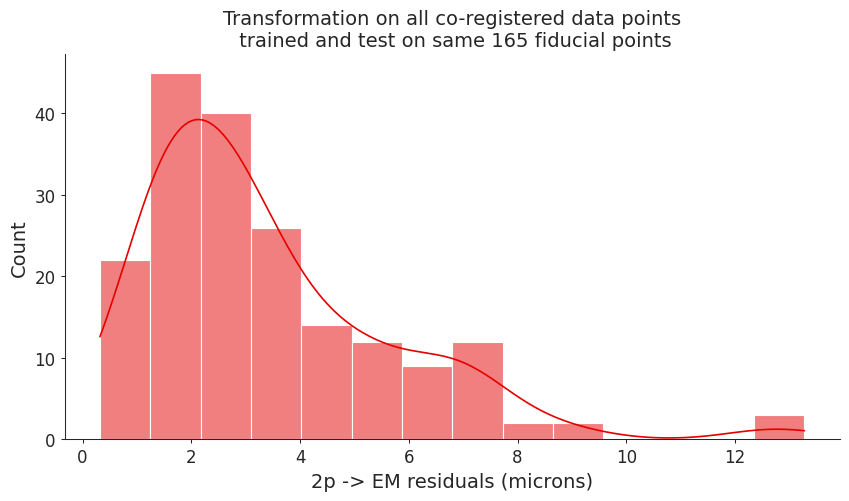

In [346]:
# estimate transformation
tform_allpts = coregister.transform.Transform(json=transform_obj)
tform_allpts.estimate(func_coreg_pts, em_coreg_pts)

fit_residuals = np.linalg.norm(tform_allpts.tform(func_coreg_pts)-em_coreg_pts, axis=1)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Transformation on all co-registered data points\n trained and test on same 165 fiducial points')
sns.histplot(fit_residuals,ax=ax,kde=True,color=cc[1])
ax.set_xlabel('2p -> EM residuals (microns)')

## evaluate transformation

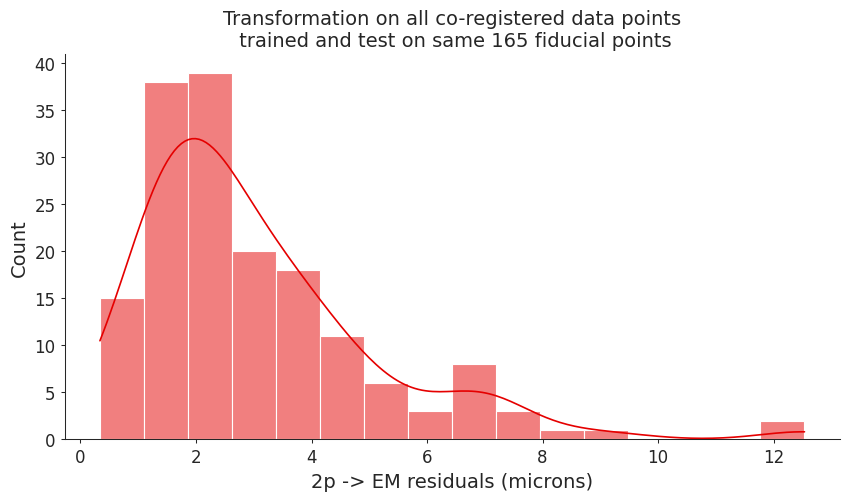

In [16]:
fit_residuals = np.linalg.norm(tform.tform(func_coreg_pts)-em_coreg_pts, axis=1)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Transformation on all co-registered data points\n trained and test on same 165 fiducial points')
sns.histplot(fit_residuals,ax=ax,kde=True,color=cc[1])
ax.set_xlabel('2p -> EM residuals (microns)')
plt.savefig(os.path.join(PlotDir,'residuals_fitonall.png'))

In [17]:
# evaluate l1out residual for all points
# TODO make helper method in coregister

# build leave-one-out dataset
@dataclasses.dataclass
class L1OutResult:
    src_pt : np.ndarray
    dst_pt : np.ndarray
    predicted_dst : np.ndarray
    pt_idx : str


l1out_transform_obj = {
        "name": "TransformList",
        "transforms": transform_list[:]
    }

src_vol_label = "opt"
dst_vol_label = "em"
l1out_src_pts = func_coreg_pts[:]
l1out_dst_pts = em_coreg_pts[:]




In [18]:
results = []
mean_residuals = []

#Loop over each cell and calculate tranform without it
for idx in range(l1out_src_pts.shape[0]):
    pts_mask = np.zeros(l1out_src_pts.shape[0], dtype=bool)
    pts_mask[idx] = True
    
    masked_src_pts = l1out_src_pts[~pts_mask]
    masked_dst_pts = l1out_dst_pts[~pts_mask]
    
    l1out_tform = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform.estimate(masked_src_pts, masked_dst_pts)
    
    mean_residuals.append(np.linalg.norm(tform.tform(masked_src_pts) - masked_dst_pts, axis=1).mean())
    
    
    lno_src_pts = np.array([l1out_src_pts[idx]])
    lno_dst_pts = np.array([l1out_dst_pts[idx]])
    
    predicted_dsts = l1out_tform.tform(lno_src_pts)
    
    results.append(L1OutResult(
        src_pt=lno_src_pts[0], 
        dst_pt=lno_dst_pts[0],
        predicted_dst=predicted_dsts[0],
        pt_idx=idx
    ))



In [19]:
l1out_disps = np.array([r.dst_pt - r.predicted_dst for r in results])
l1out_residuals = np.linalg.norm(l1out_disps, axis=1)

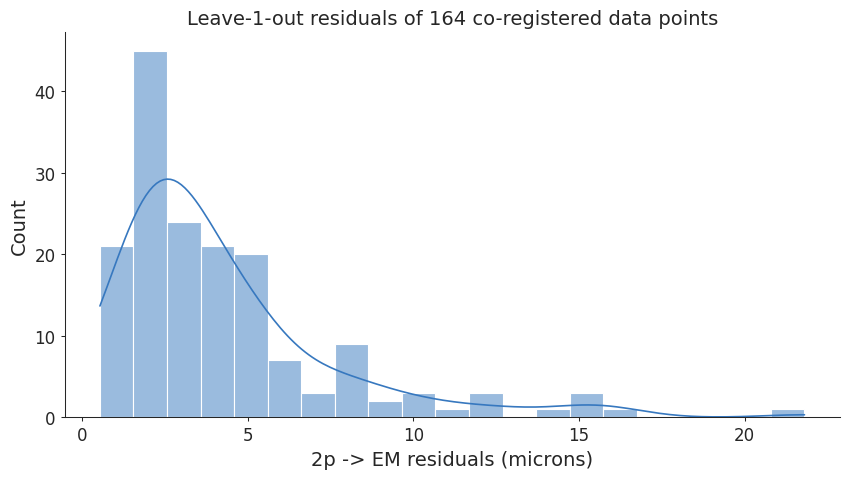

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Leave-1-out residuals of 164 co-registered data points')
sns.histplot(l1out_residuals,ax=ax,kde=True,color=cc[2])
ax.set_xlabel('2p -> EM residuals (microns)')
plt.savefig(os.path.join(PlotDir,'residuals_L1O.png'))


# fig, ax = plt.subplots(figsize=(10,5))
# ax.set_title('Residiual comparison')
# sns.histplot(fit_residuals,ax=ax,kde=True,color=cc[1],label='all')
# sns.histplot(l1out_residuals,ax=ax,kde=True,color=cc[2],label='L1O')
# ax.set_xlabel('2p -> EM residuals (microns)')
# ax.legend()
# plt.savefig(os.path.join(PlotDir,'residuals_compare.png'))


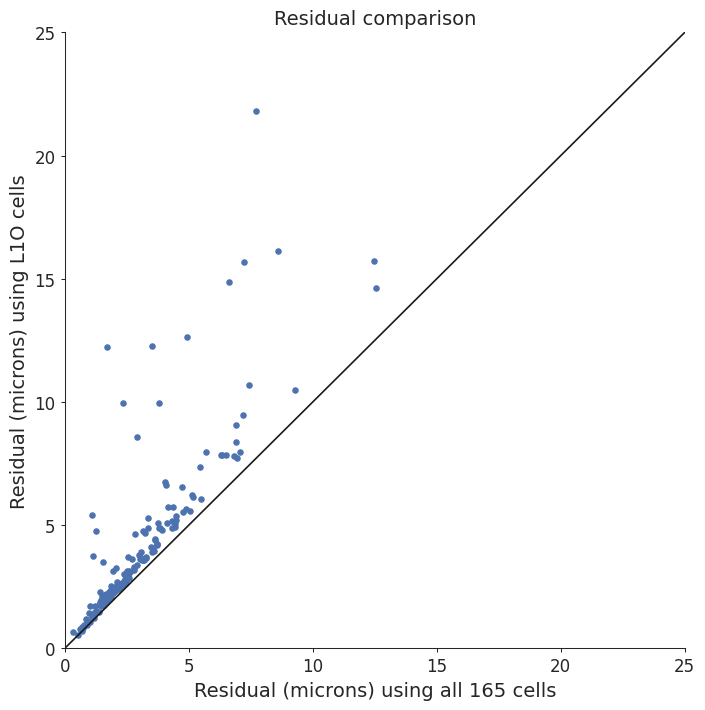

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Residual comparison')

ax.plot([0,25],[0,25],'-k')
ax.scatter(fit_residuals,l1out_residuals,s=15)

ax.set_xlabel('Residual (microns) using all 165 cells')
ax.set_ylabel('Residual (microns) using L1O cells')

ax.set_xlim([0,25]);ax.set_ylim([0,25])
plt.savefig(os.path.join(PlotDir,'residuals_compare.png'))

Text(0, 0.5, 'Delta-residual (microns): L1O - all')

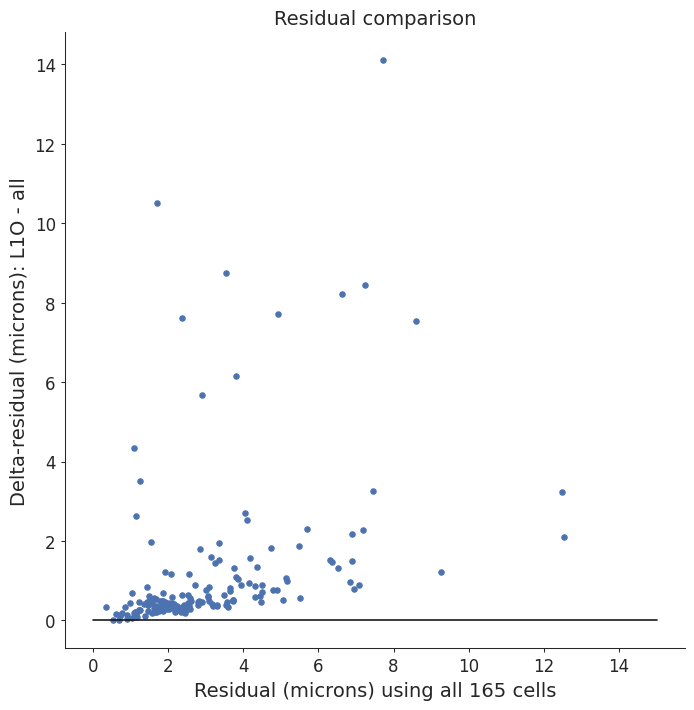

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Residual comparison')

ax.scatter(fit_residuals,l1out_residuals-fit_residuals,s=15)

ax.plot([0,15],[0,0],'-k')
ax.set_xlabel('Residual (microns) using all 165 cells')
ax.set_ylabel('Delta-residual (microns): L1O - all')

# ax.set_xlim([0,25]);ax.set_ylim([0,25])
# plt.savefig(os.path.join(PlotDir,'residuals_compare.png'))

## apply transformation

In [82]:
em_final_voxel_size = np.array([4.85, 4.85, 45])

#Get 2p functional data for column 1 volumn 3
nwb_file = '/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data/nwbs/processed/M409828_13_20181213.nwb'
with ROI_mask_nwb(nwb_file, vol=3, mode="r") as rmn:
    # import pdb; pdb.set_trace()
    all_roi_info = [*rmn.yield_roi_info()] 

In [30]:
all_roi_raw_center_pts[0]

array([359.30295343,  46.6542582 ,   0.        ])

In [31]:
all_roi_func_coreg_pts[0]

array([343.09136814, 271.41003318, 267.        ])

In [83]:
# Get 2p ROI center of mass 
all_roi_raw_center_pts = np.array([center_from_pix_mask(roi.pix_mask).tolist() + [roi.plane_z] for roi in all_roi_info])

# Get names
all_roi_names = np.array([roi.name for roi in all_roi_info])

#Get pika scores
pika_threshold = 0.5
all_pika_scores = np.array([roi.pika_score for roi in all_roi_info])
all_valid_cells = all_pika_scores > pika_threshold

# Transform raw 2p coordinates into co-registration space (micron space)
all_roi_func_coreg_pts = transform_pts(func_raw2coreg_tform, all_roi_raw_center_pts)

#Get z-depth of all cells in microns
all_roi_depths = np.array([depth_dict[(1,roi.volume,roi.plane_z + 1)] for roi in all_roi_info])



In [84]:
#Transform 2p functional locations to EM using transform created using all co-registered cells
all_roi_em_coreg_pts = tform.tform(all_roi_func_coreg_pts)

# Transform coregistered points back into EM space 
all_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, all_roi_em_coreg_pts)
all_roi_em_final_pts_nms = all_roi_em_final_pts_voxels * em_final_voxel_size

In [86]:
# Get co-registered test set
test_set_names = np.array([*test_set_name_to_final_em_nm.keys()])
test_set_em_final_pts_nms = np.array([*test_set_name_to_final_em_nm.values()])

# TODO implement this as a utility
def get_array_subset_indices(set_arr, subset_arr):
    set_arr_sorted = np.argsort(set_arr)
    subset_arr_pos = np.searchsorted(set_arr[set_arr_sorted], subset_arr)
    indices = set_arr_sorted[subset_arr_pos]
    return indices


In [87]:
#Get transformed points in em space of cells from cave client coregistration table 
coreg_table_idxs = get_array_subset_indices(all_roi_names, coreg_table_russelkeys)
coreg_table_centers_em_nm = all_roi_em_final_pts_nms[coreg_table_idxs]


In [90]:
test_centers_func_raw, all_roi_func_coreg_pts[test_set_idxs], test_centers_em_nm, test_set_names

(array([[140.80700456, 259.89984893,   4.        ],
        [208.36371672, 289.84393797,   1.        ],
        [349.23919373, 239.3329567 ,   1.        ],
        [300.79612641, 149.68311293,   0.        ],
        [257.89006003, 231.62868805,   1.        ],
        [259.57546446, 178.97418735,   3.        ],
        [244.78739822, 231.69834862,   2.        ],
        [243.2197419 , 348.2094039 ,   4.        ],
        [169.97752923, 278.44125958,   0.        ],
        [214.93671299, 164.30274428,   3.        ],
        [210.9295254 , 362.80063102,   3.        ],
        [176.20626769, 301.97352698,   2.        ],
        [271.23571156, 295.68424022,   2.        ],
        [144.3099366 , 235.33400512,   2.        ],
        [143.6835724 , 234.92497789,   3.        ],
        [230.72726651, 368.16224059,   5.        ],
        [322.25175189, 260.08776692,   0.        ],
        [228.45460369, 165.56161244,   2.        ],
        [226.71052134, 348.45409071,   2.        ],
        [150

In [88]:
#Get test set indices
test_set_idxs = get_array_subset_indices(all_roi_names, test_set_names)

#Transform test points from coregistration space to raw pixel space
test_centers_func_raw = all_roi_raw_center_pts[test_set_idxs]
corr_pts_func_raw = transform_pts(func_coreg2raw_tform, func_coreg_pts)

#Grab test set in em space
test_centers_em_nm = all_roi_em_final_pts_nms[test_set_idxs]

#Transform points used for creating transform into em space
corr_pts_em_voxels = transform_pts(em_coreg2final_tform, em_coreg_pts)
corr_pts_em_nm = corr_pts_em_voxels * em_final_voxel_size

#Get residuals on test cells
disps = test_centers_em_nm - test_set_em_final_pts_nms
test_set_residuals = np.linalg.norm(disps, axis=1)
print(np.mean(np.abs(disps), axis=0)/1000, 'microns')

[2.51490292 4.57940053 1.60805223] microns


In [33]:
indy = []; indy2 = []; indy3 = []
for ii, k in enumerate(coreg_table_russelkeys):
    if k in test_set_name_to_final_em_nm.keys():
        indy.append(ii)
        indy3.append([jj for jj, roi in enumerate(test_set_name_to_final_em_nm.keys()) if k == roi][0])
    else:
        indy2.append(ii)
print(len(indy))


19


In [19]:
#So these 19 neurons in the coreg_table are part of the test set
coreg_ptpos = np.stack(coreg_table['pt_position'])
coreg_ptpos[indy] - test_set_em_final_pts_nms[indy3]


array([[7., 0., 0.],
       [5., 0., 0.],
       [0., 2., 0.],
       [5., 5., 0.],
       [3., 6., 0.],
       [3., 7., 0.],
       [4., 0., 0.],
       [3., 3., 0.],
       [7., 1., 0.],
       [2., 3., 0.],
       [6., 7., 0.],
       [1., 8., 0.],
       [2., 8., 0.],
       [8., 6., 0.],
       [4., 2., 0.],
       [6., 1., 0.],
       [0., 2., 0.],
       [4., 0., 0.],
       [4., 0., 0.]])

In [173]:
#And the remaining are most likely part of the "training set" or what was used to calculate the transform
for ii in indy2:
    ptpos = coreg_ptpos[ii]
    delta = corr_pts_em_nm - ptpos
    residuals = np.linalg.norm(delta, axis=1)

    jj = np.argmin(residuals)
    print(f'Neuron {ii:2d} in cave-client coreg table. delta =', delta[jj]/1000, 'residual = ',np.min(residuals)/1000)
        

Neuron  0 in cave-client coreg table. delta = [ 0.47686659  0.75080849 -0.5618833 ] residual =  1.0520589215031984
Neuron  1 in cave-client coreg table. delta = [-0.70721172 -0.59230991  0.0320484 ] residual =  0.9230420065049373
Neuron  2 in cave-client coreg table. delta = [-1.26422671  0.02836028 -0.2450536 ] residual =  1.2880701628257967
Neuron  5 in cave-client coreg table. delta = [-1.18851514 -0.07229849 -1.030921  ] residual =  1.574989975117674
Neuron  7 in cave-client coreg table. delta = [ 0.01212472 -0.45544042 -0.8085908 ] residual =  0.9281120969445491
Neuron  8 in cave-client coreg table. delta = [-0.40640667  0.36291351 -0.221265  ] residual =  0.5880738033503271
Neuron  9 in cave-client coreg table. delta = [-0.40640667  0.36291351 -0.221265  ] residual =  0.5880738033503271
Neuron 12 in cave-client coreg table. delta = [-0.81066914  0.91533169 -0.4340379 ] residual =  1.2974611603144883
Neuron 13 in cave-client coreg table. delta = [0.61000614 1.36953369 0.4130143 ] 

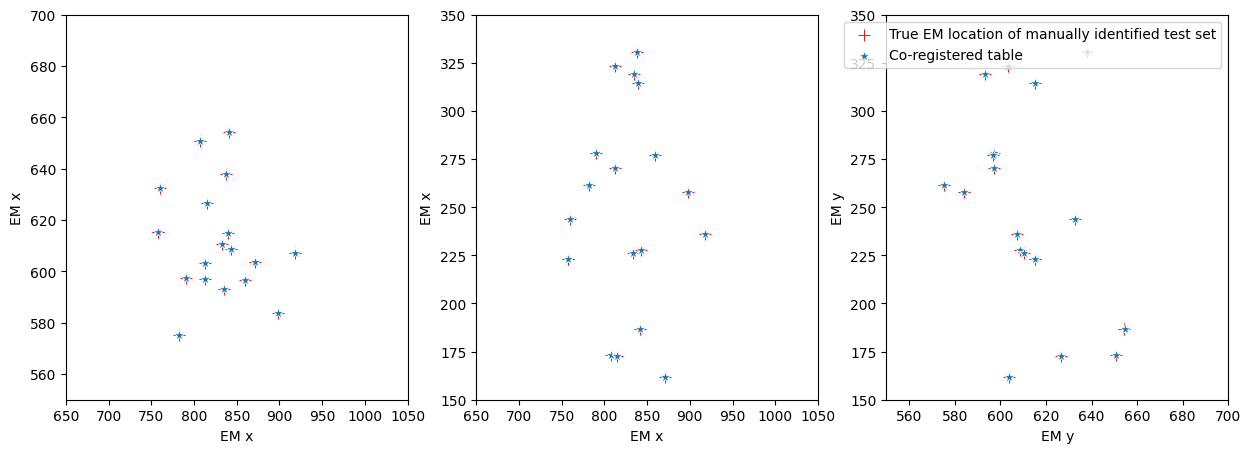

In [30]:
y2 = np.stack(coreg_table['pt_position'][indy])
y3 = test_set_em_final_pts_nms[indy3]

scalar = 1000

fig, axes = plt.subplots(1,3,figsize=(15,5))
# plt.suptitle('Co-registration of 22 test cells in em-space')
axes_labels = ['x','y','z']; lims = [[650,1050],[550,700],[150,350]]
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    ax = axes[ii]
    # sns.scatterplot(x=corr_pts_em_nm[:, _xaxis]/scalar, y=corr_pts_em_nm[:, _yaxis]/scalar, marker='.',s=70, ax=ax,label='Co-registered cells used for creating transform')
    # sns.scatterplot(x=test_set_em_final_pts_nms[:, _xaxis]/scalar, y=test_set_em_final_pts_nms[:, _yaxis]/scalar, marker='.',s=70, ax=ax,label='EM location of test set after transform')
    sns.scatterplot(x=y3[:, _xaxis]/scalar, y=y3[:, _yaxis]/scalar,marker= '+', s=70, ax=ax, color="r",label='True EM location of manually identified test set')
    sns.scatterplot(x=y2[:, _xaxis]/scalar, y=y2[:, _yaxis]/scalar,marker= '*', s=70, ax=ax,label='Co-registered table')

    if ii < 2:
        ax.get_legend().remove()
    ax.set_xlim(lims[_xaxis])
    ax.set_ylim(lims[_yaxis])
    ax.set_xlabel(f'EM {axes_labels[_xaxis]}')
    ax.set_ylabel(f'EM {axes_labels[_xaxis]}')
    

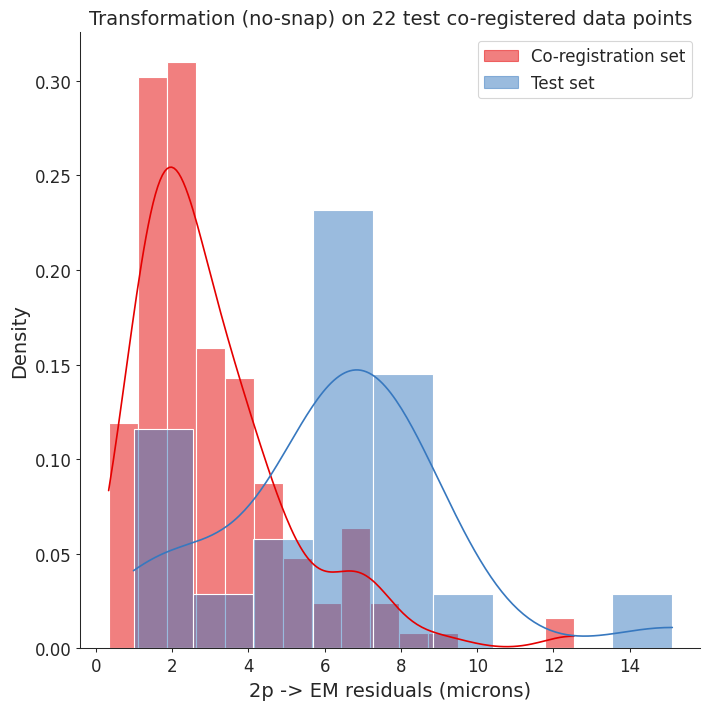

In [44]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Transformation (no-snap) on 22 test co-registered data points')
sns.histplot(fit_residuals,ax=ax,kde=True,color=cc[1],stat='density')
sns.histplot(test_set_residuals/1000,ax=ax,kde=True,color=cc[2],stat='density')
ax.set_xlabel('2p -> EM residuals (microns)')

legend_elements = [Patch(facecolor=cc[1],alpha=0.5, edgecolor=cc[1],label='Co-registration set'),
                   Patch(facecolor=cc[2],alpha=0.5, edgecolor=cc[2],label='Test set')]
ax.legend(handles=legend_elements)
plt.savefig(os.path.join(PlotDir,'residuals_test.png'))

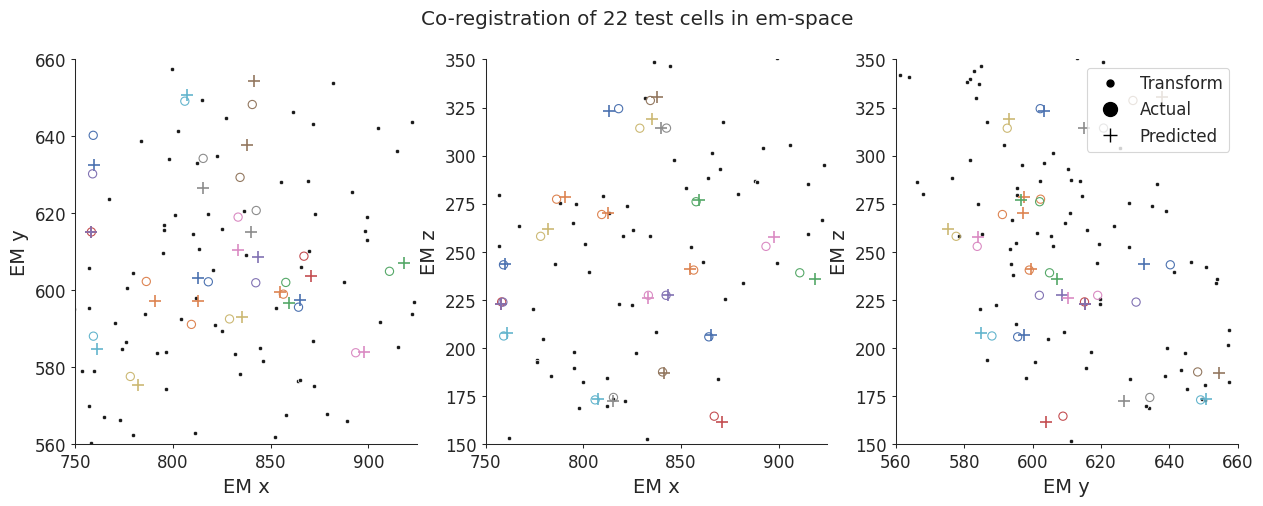

In [26]:
import matplotlib as mpl
scalar = 1000
ax_sizes = (512, 512, 6)

fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('Co-registration of 22 test cells in em-space')
# axes_labels = ['x','y','z']; lims = [[650,1050],[550,700],[150,350]]
axes_labels = ['x','y','z']; lims = [[750,925],[560,660],[150,350]]
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    ax = axes[ii]
    sns.scatterplot(x=corr_pts_em_nm[:, _xaxis]/scalar, y=corr_pts_em_nm[:, _yaxis]/scalar, marker='.',color='k',s=40, ax=ax)#,label='Co-registered cells used for creating transform')
    # sns.scatterplot(x=test_set_em_final_pts_nms[:, _xaxis]/scalar, y=test_set_em_final_pts_nms[:, _yaxis]/scalar, marker='.',s=70, ax=ax,label='EM location of test set after transform')
    # sns.scatterplot(x=test_centers_em_nm[:, _xaxis]/scalar, y=test_centers_em_nm[:, _yaxis]/scalar,marker= '+', s=70, ax=ax, color="r",label='True EM location of manually identified test set')

    for jj in range(test_set_em_final_pts_nms.shape[0]):
        
        color = ax.scatter(test_set_em_final_pts_nms[jj, _xaxis]/scalar, test_set_em_final_pts_nms[jj, _yaxis]/scalar,marker= '+', s=70).get_facecolors()[0]
        ax.scatter(test_centers_em_nm[jj, _xaxis]/scalar, test_centers_em_nm[jj, _yaxis]/scalar,facecolors="none", edgecolors=color, marker='o',s=35)

    # sns.scatterplot(x=coreg_table_centers_em_nm[indy2, _xaxis]/scalar, y=coreg_table_centers_em_nm[indy2, _yaxis]/scalar,marker= '*', s=70, ax=ax,label='Co-registered table')

    if ii == 2:
        ax.legend(handles=[
            mpl.lines.Line2D([0], [0],lw=0, label="Transform", marker=".", color="black", markersize=10),
            mpl.lines.Line2D([0], [0],lw=0, label="Actual", marker="o", color="none", markerfacecolor="black", markersize=10),
            mpl.lines.Line2D([0], [0],lw=0, label="Predicted", marker="+", color="black", markersize=10)
        ],  bbox_transform=ax.transAxes)
    ax.set_xlim(lims[_xaxis])
    ax.set_ylim(lims[_yaxis])
    ax.set_xlabel(f'EM {axes_labels[_xaxis]}')
    ax.set_ylabel(f'EM {axes_labels[_yaxis]}')
    
plt.savefig(os.path.join(PlotDir,'EM_location_predvtrue.pdf'))

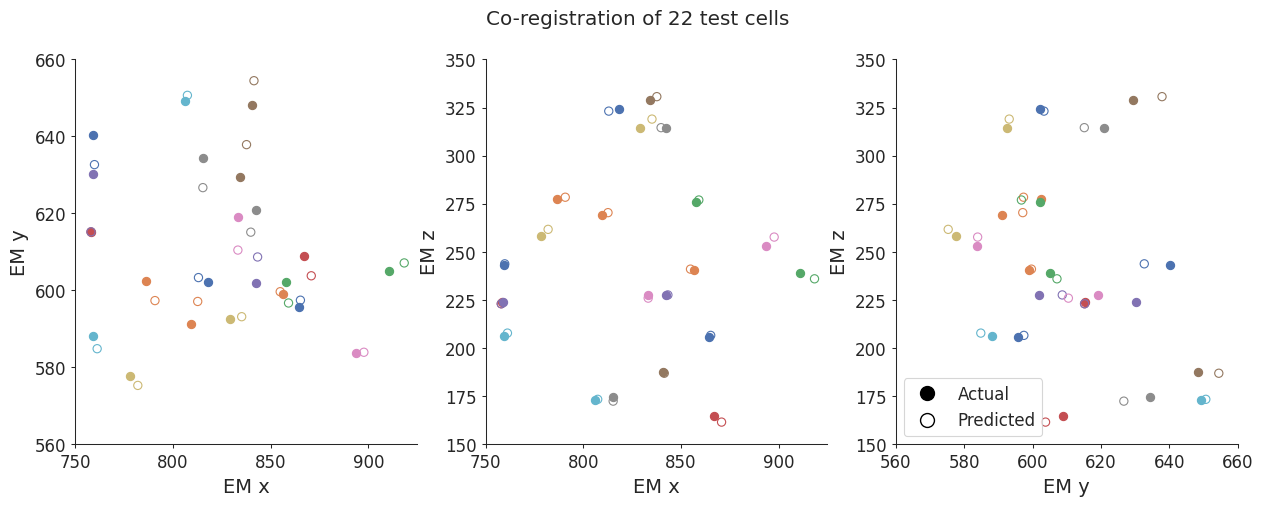

In [60]:


ax_sizes = (512, 512, 6)

fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('Co-registration of 22 test cells')
axes_labels = ['x','y','z']; lims = [[750,925],[560,660],[150,350]]
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    ax = axes[ii]
    # ax.scatter(corr_pts_em_nm[:, _xaxis]/scalar, corr_pts_em_nm[:, _yaxis]/scalar, marker='.',color='k',s=40, label='Co-registered cells used for creating transform')
    for jj in range(test_set_em_final_pts_nms.shape[0]):
        color = ax.scatter(test_centers_em_nm[jj, _xaxis]/scalar, test_centers_em_nm[jj, _yaxis]/scalar,marker= 'o', s=35).get_facecolors()[0]
        ax.scatter(test_set_em_final_pts_nms[jj, _xaxis]/scalar, test_set_em_final_pts_nms[jj, _yaxis]/scalar,facecolors="none", edgecolors=color, marker='o',s=35)

    # sns.scatterplot(coreg_table_centers_em_nm[indy2, _xaxis]/scalar, coreg_table_centers_em_nm[indy2, _yaxis]/scalar,marker= '*', s=70, label='Co-registered table')
    if ii == 2:
        ax.legend(handles=[
            mpl.lines.Line2D([0], [0],lw=0, label="Actual", marker="o", color="none", markerfacecolor="black", markersize=10),
            mpl.lines.Line2D([0], [0],lw=0, label="Predicted", marker="o", color="none", markeredgecolor="black", markersize=10)
        ],  bbox_transform=ax.transAxes)
    ax.set_xlim(lims[_xaxis])
    ax.set_ylim(lims[_yaxis])
    ax.set_xlabel(f'EM {axes_labels[_xaxis]}')
    ax.set_ylabel(f'EM {axes_labels[_yaxis]}')
plt.savefig(os.path.join(PlotDir,'EM_location_predvtrue2.pdf'))

## correspondence to EM

In [45]:
#Now we'll try to match transformed em position to a cell in the em volume
all_roi_em_final_pts_nms.shape

(7523, 3)

In [46]:
cave_client = caveclient.CAVEclient('v1dd')

In [29]:
em_client.query_table("nucleus_detection_v0")

id                          created  superceded_id valid  \
0       228132 2022-02-04 06:21:10.292663+00:00            NaN     t   
1       543247 2022-02-04 06:21:10.295034+00:00            NaN     t   
2       203262 2022-02-04 06:21:10.297516+00:00            NaN     t   
3       350562 2022-02-04 06:21:10.300143+00:00            NaN     t   
4       718122 2022-02-04 06:21:10.302911+00:00            NaN     t   
...        ...                              ...            ...   ...   
207450  527607 2022-02-04 06:31:31.245454+00:00            NaN     t   
207451  168582 2022-02-04 06:31:31.246802+00:00            NaN     t   
207452   29422 2022-02-04 06:31:31.248226+00:00            NaN     t   
207453  422767 2022-02-04 06:31:31.249663+00:00            NaN     t   
207454  474107 2022-02-04 06:31:31.251020+00:00            NaN     t   

            volume    pt_supervoxel_id          pt_root_id  \
0       458.464831   87485049993200655  864691132737039043   
1        73.345940  106490931167272264  864691132870078055   
2       338.276613   87197526360541948  864691132654552792   
3       326.965400   94866276031228266  864691132773514104   
4       333.888647  118515535938912588  864691132774106773   
...            ...                 ...                 ...   
207450  100.547645  105284974949287046  864691132639606383   
207451  369.919126   83482550844689534  864691133042980384   
207452  285.031368                   0                   0   
207453  394.724290   99723368244567127  864691132851361283   
207454   72.433553  101918819295118594  864691132492993878   

                       pt_position          bb_start_position  \
0         [632828, 749849, 738270]    [626620, 746124, 78876]   
1         [1304922, 977915, 83880]    [1299179, 974035, 8536]   
2         [624680, 531094, 283770]    [619869, 525818, 30089]   
3         [894573, 478559, 163530]    [891003, 473981, 17111]   
4        [1729859, 674111, 781200]   [1722177, 667205, 83852]   
...                            ...                        ...   
207450   [1262940, 628094, 734445]   [1258827, 624990, 78856]   
207451    [491518, 1057067, 92070]    [485388, 1052877, 9399]   
207452     [302330, 415005, 81855]     [294182, 409340, 8410]   
207453    [1065603, 538932, 36405]    [1061335, 533267, 3434]   
207454  [1143281, 1046203, 446085]  [1140487, 1043332, 47821]   

                  bb_end_position  
0         [638493, 753341, 80137]  
1         [1311595, 983192, 9511]  
2         [629414, 535750, 31050]  
3         [898608, 483370, 18134]  
4        [1736610, 682026, 84536]  
...                           ...  
207450   [1267053, 630810, 79453]  
207451   [497571, 1061413, 10389]  
207452     [308770, 420825, 9099]  
207453    [1070182, 544054, 4399]  
207454  [1146152, 1049462, 48369]  

[207455 rows x 10 columns]

In [47]:
# define bounding box for table query
min_nm = all_roi_em_final_pts_nms.min(axis=0)
max_nm = all_roi_em_final_pts_nms.max(axis=0)

# 40 um buffer around area
buffer_um = 40
k = 1000
buffer_nm = buffer_um * k
buffer = np.array((buffer_nm, buffer_nm, buffer_nm))

query_bbox = np.array([
    min_nm - buffer,
    max_nm + buffer
])

In [48]:
#Get all cells in EM volume within bounding region
res = cave_client.materialize.query_table(
    "nucleus_detection_v0",filter_spatial_dict={"pt_position": query_bbox})

In [49]:
#Extract point position 
nucleus_pts = np.array([i for i in res.pt_position])
nucleus_ids = np.array([i for i in res.pt_root_id])
print(nucleus_pts.shape)


(21515, 3)


In [50]:
# match using simple euclidean distance
kdt = scipy.spatial.KDTree(nucleus_pts)

distances, indices = kdt.query(all_roi_em_final_pts_nms, k=2)
rod = distances[:, 0] / distances[:, 1]
eu_predicted_nucleus_pts_centroids = nucleus_pts[indices[:, 0]]

In [51]:
nNeurons = all_roi_em_final_pts_nms.shape[0]

# match using 2d refinement
refinement_cutoff_nm = 6000
refinement_cutoff_rod = 0.75    #ratio between the closest and second closet em object
k=2
axes_2d = [0, 2]

#Define KD-tree based on em data
kdt = scipy.spatial.KDTree(nucleus_pts)

#Query the first and second nearest EM neighbours of the 2p data
distances, indices = kdt.query(all_roi_em_final_pts_nms, k=k)
rod = distances[:, 0] / distances[:, 1]

#Identify transformed 2p locations that are greater than 6microns to the nearest EM centroid AND has 2nd EM centroid that is >=8mm away 
refine_mask = (distances[:, 0] >= refinement_cutoff_nm) & (rod >= refinement_cutoff_rod)
print(f'{np.sum(refine_mask)}/{nNeurons} neurons are greater than {refinement_cutoff_nm/1000} microns from an EM centroid and have a cell distance ratio greater than {refinement_cutoff_rod}')

3412/7523 neurons are greater than 6.0 microns from an EM centroid and have a cell distance ratio greater than 0.75


In [52]:
#Get nucleus centroids from EM data 
predicted_nucleus_pts_centroids = nucleus_pts[indices[:, 0]]

swap_mask = np.zeros((nNeurons),dtype=bool)
#Loop over each cell and create unique KD tree based on 2 closest neurons
for idx in np.argwhere(refine_mask):
    #Create tree based only on x and z dimensions in EM 
    kdt_2d = scipy.spatial.KDTree(nucleus_pts[indices[idx]][0, :, axes_2d].T)
    
    #Get 2D xz distance
    dists_2d, idxs_2d = kdt_2d.query([all_roi_em_final_pts_nms[idx, axes_2d]])

    #Choose closest neuron based on xz distance
    nucleus_idx = indices[idx][0][idxs_2d[0]]

    if idxs_2d[0] ==  1:
        swap_mask[idx] = True

    #Update
    predicted_nucleus_pts_centroids[idx] = nucleus_pts[nucleus_idx]

print(f'{np.sum(swap_mask)}/{np.sum(refine_mask)} of these, we chose the 2nd closest cell')

1240/3412 of these, we chose the 2nd closest cell


In [56]:
swap_mask[test_set_idxs]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False])

In [54]:
# compare the residuals of transformed test set before and after it was snapped to an EM centroid
pre_snap_test_disps = all_roi_em_final_pts_nms[test_set_idxs] - test_set_em_final_pts_nms
pre_snap_test_dists = np.linalg.norm(pre_snap_test_disps, axis=1)
post_snap_test_disps = predicted_nucleus_pts_centroids[test_set_idxs] - test_set_em_final_pts_nms
post_snap_test_dists = np.linalg.norm(post_snap_test_disps, axis=1)


[1095.71090199 1958.8088956   776.60056374]


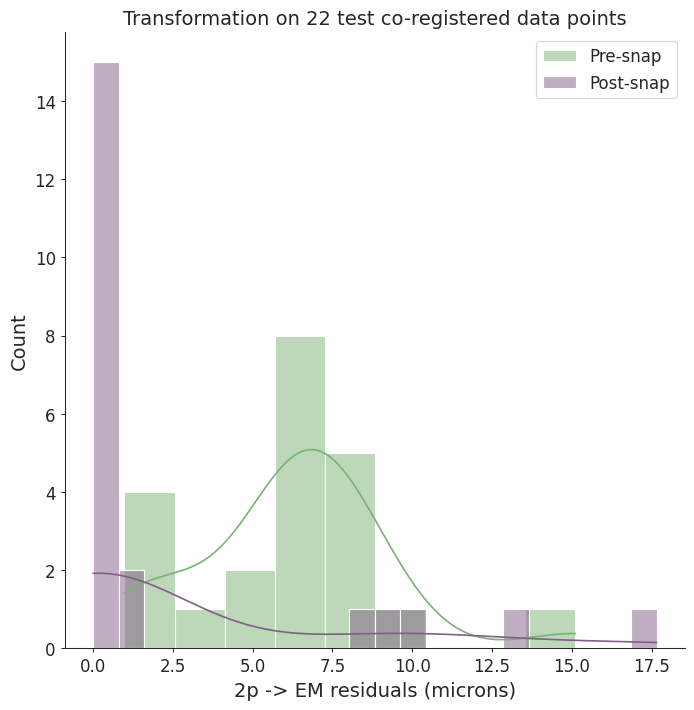

In [55]:

print(np.mean(np.abs(post_snap_test_disps), axis=0))

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Transformation on 22 test co-registered data points')
sns.histplot(pre_snap_test_dists/1000,ax=ax,kde=True,color=cc[3],label='Pre-snap')
sns.histplot(post_snap_test_dists/1000,ax=ax,kde=True,color=cc[4],label='Post-snap')
ax.legend()
ax.set_xlabel('2p -> EM residuals (microns)')
plt.savefig(os.path.join(PlotDir,'residuals_PreVPost-Snap.png'))

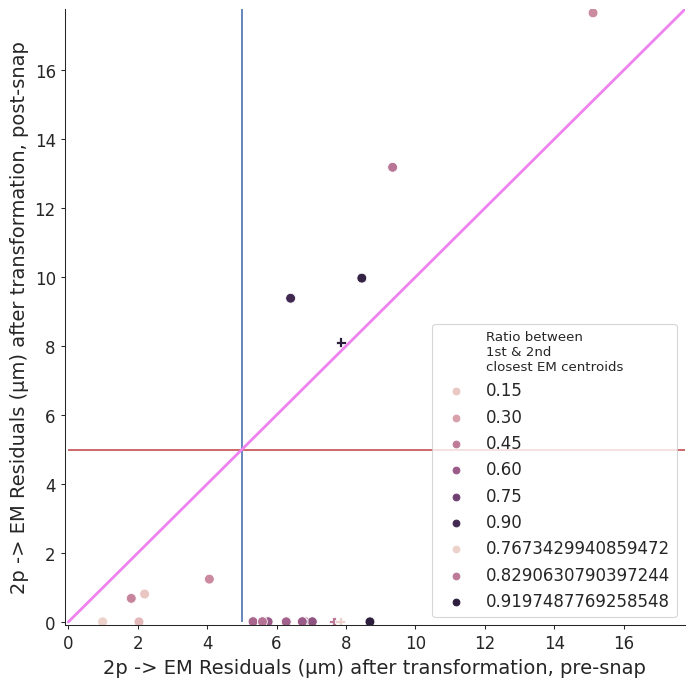

In [65]:

scalar = 1000
fig, ax = plt.subplots(figsize=(8,8))

mask = swap_mask[test_set_idxs]
sns.scatterplot(x=pre_snap_test_dists[~mask]/scalar, y=post_snap_test_dists[~mask]/scalar, hue=rod[test_set_idxs][~mask],s=50,ax=ax,marker='o')
sns.scatterplot(x=pre_snap_test_dists[mask]/scalar, y=post_snap_test_dists[mask]/scalar, hue=rod[test_set_idxs][mask],s=50,ax=ax,marker='P')

ax.legend(title='Ratio between\n1st & 2nd\nclosest EM centroids')
ax.set_xlabel('2p -> EM Residuals (\u03BCm) after transformation, pre-snap')
ax.set_ylabel('2p -> EM Residuals (\u03BCm) after transformation, post-snap')

xymax = np.max([(post_snap_test_dists.max()+100)/scalar,(pre_snap_test_dists.max()+100)/scalar])
xplot = np.linspace(0, xymax, 1000)
ax.vlines([5000/scalar], ymin=0, ymax=xymax)
ax.hlines([5000/scalar], xmin=0, xmax=xymax, colors=["r"])
ax.plot(xplot, xplot, linewidth=2, c="violet")
ax.set_xlim(-100/scalar, xymax)
ax.set_ylim(-100/scalar, xymax)

plt.savefig(os.path.join(PlotDir,'residuals_PreVPost-Snap.png'))

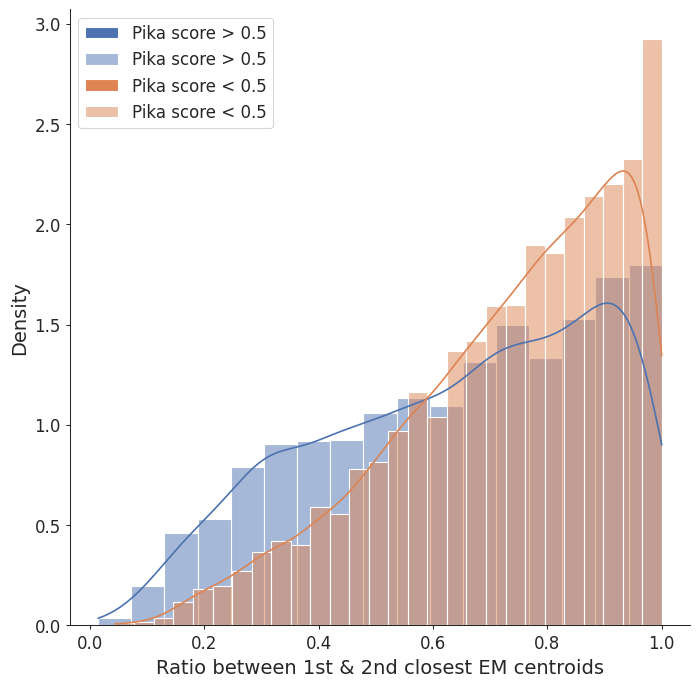

In [49]:


fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(rod[all_valid_cells],ax=ax,kde=True,label='Pika score > 0.5',stat='density')
sns.histplot(rod[~all_valid_cells],ax=ax,kde=True,label='Pika score < 0.5',stat='density')
# sns.kdeplot(rod[test_set_idxs],ax=ax,label='Test-set')
ax.set_xlabel('Ratio between 1st & 2nd closest EM centroids')
ax.legend()
plt.savefig(os.path.join(PlotDir,'distance-ratio_btw2closestcentroids.png'))

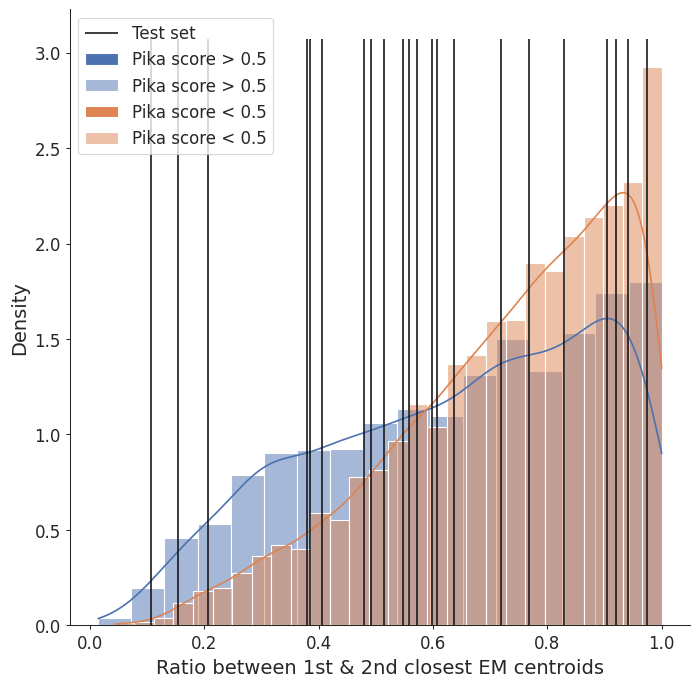

In [183]:


fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(rod[all_valid_cells],ax=ax,kde=True,label='Pika score > 0.5',stat='density')
sns.histplot(rod[~all_valid_cells],ax=ax,kde=True,label='Pika score < 0.5',stat='density')
ax.vlines(rod[test_set_idxs],*ax.get_ylim(),color='k',label='Test set')
# ax.set_xlabel('Ratio between 1st & 2nd closest EM centroids')
ax.legend()
# plt.savefig(os.path.join(PlotDir,'distance-ratio_btw2closestcentroids.png'))

In [59]:
#Determine agreement threshold
agreement_thres = 4000
disagreement_mask = (post_snap_test_dists >= agreement_thres)
print(disagreement_mask.sum(), len(post_snap_test_dists))
print((~disagreement_mask).sum() / len(post_snap_test_dists))

rod[test_set_idxs][disagreement_mask]

5 22
0.7727272727272727


array([0.9416961 , 0.37907754, 0.47947691, 0.90363732, 0.91974878])

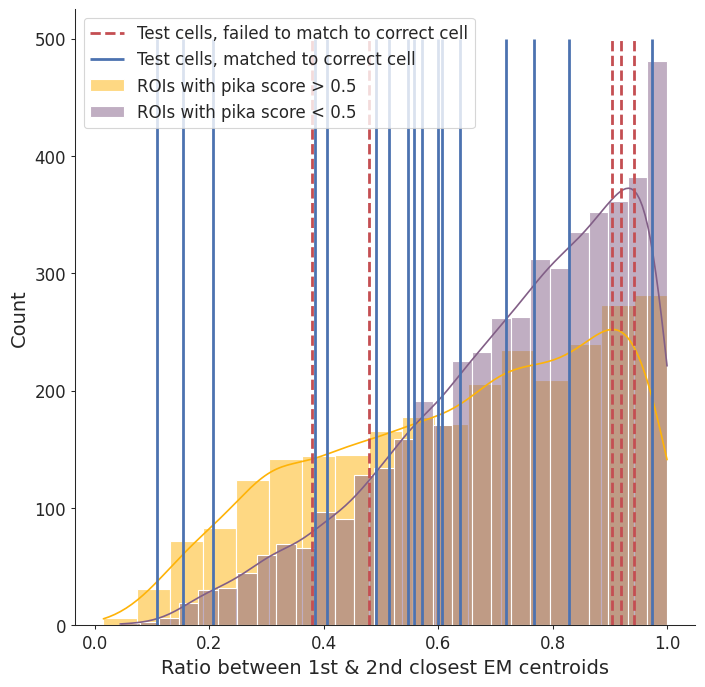

In [77]:

fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(rod[all_valid_cells],ax=ax,kde=True,label='ROIs with pika score > 0.5',color=cc[0])
sns.histplot(rod[~all_valid_cells],ax=ax,kde=True,label='ROIs with pika score < 0.5',color=cc[4])


dist_ratio_test = rod[test_set_idxs]

ax.vlines(dist_ratio_test[disagreement_mask],0, 500,color='r',lw=2,ls='--',label='Test cells, failed to match to correct cell')
ax.vlines(dist_ratio_test[~disagreement_mask],0, 500,color='b',lw=2,ls='-',label='Test cells, matched to correct cell')
# ax.set_xlabel('Ratio between 1st & 2nd closest EM centroids')
ax.legend()
ax.set_xlabel('Ratio between 1st & 2nd closest EM centroids')

plt.savefig(os.path.join(PlotDir,'notthebestmetric.png'))

In [440]:
rod[test_set_idxs][~disagreement_mask]

array([0.82906308, 0.5578564 , 0.63755864, 0.71851105, 0.51466032,
       0.97371675, 0.57158554, 0.6071571 , 0.20711609, 0.5474772 ,
       0.59909227, 0.49219014, 0.10796504, 0.76734299, 0.38430558,
       0.1541723 , 0.40641703])

In [120]:
disagreement_points = test_set_em_final_pts_nms[disagreement_mask]

In [113]:
# visualize what "snapping" to EM nuclei does in planes
snap_residuals = predicted_nucleus_pts_centroids - all_roi_em_final_pts_nms

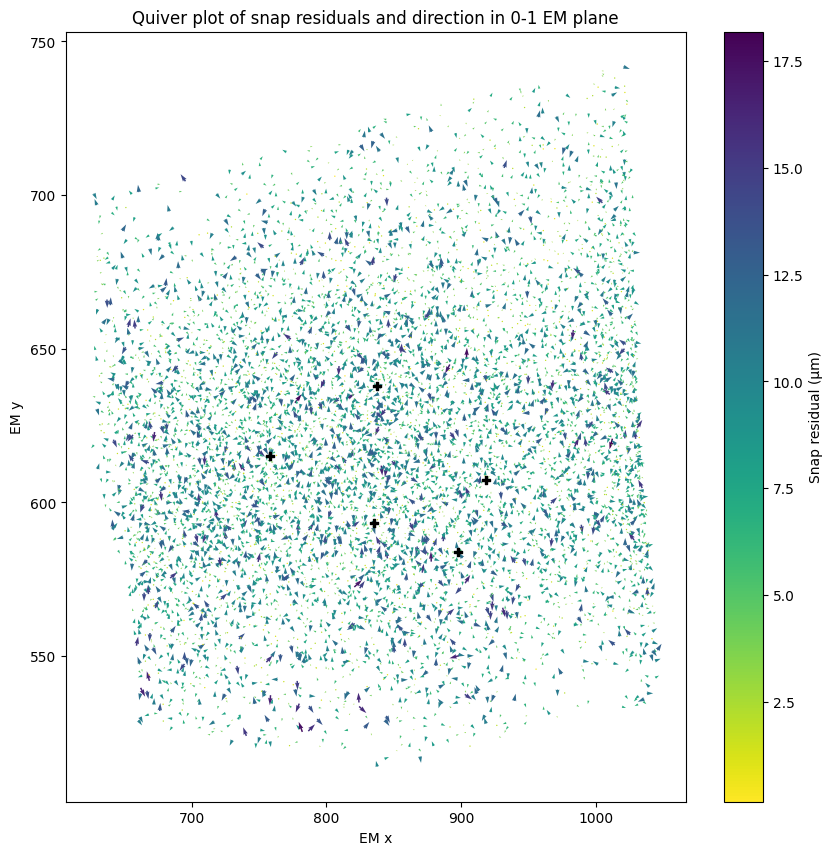

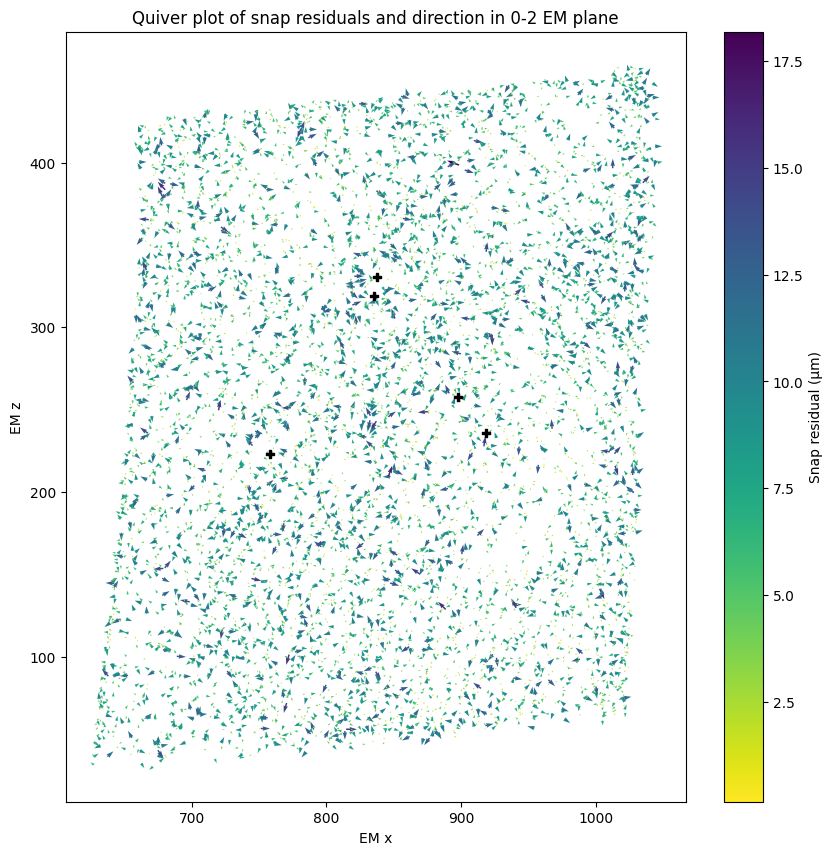

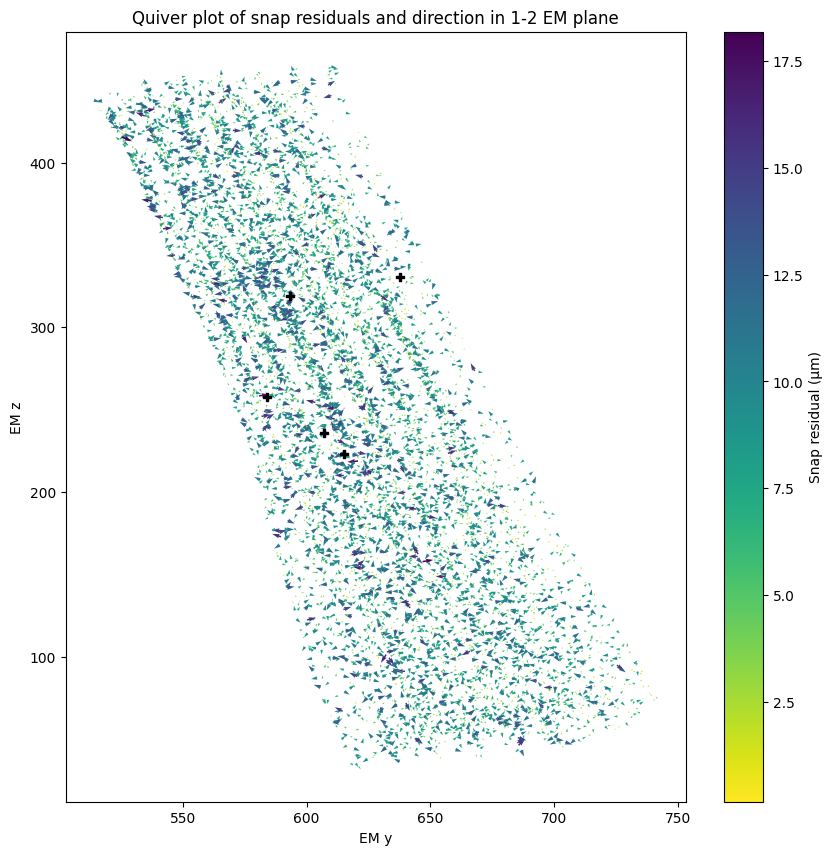

In [148]:
#Create colorbar
cmap = 'viridis_r'
snap_dists = np.linalg.norm(snap_residuals, axis=1)
norm = plt.Normalize(snap_dists.min()/scalar, snap_dists.max()/scalar)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

axes_labels = ['x','y','z']
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    fig, ax = plt.subplots(figsize=(10,10))

    # ax = axes[0]
    ax.set_title(f'Quiver plot of snap residuals and direction in {_xaxis}-{_yaxis} EM plane')
    d_ = np.linalg.norm(snap_residuals[:, xy], axis=1)
    ax.quiver(all_roi_em_final_pts_nms[:, _xaxis]/scalar, all_roi_em_final_pts_nms[:, _yaxis]/scalar, snap_residuals[:, _xaxis]/scalar, snap_residuals[:, _yaxis]/scalar, d_ , cmap=cmap)

    ax.scatter(disagreement_points[:, _xaxis]/scalar, disagreement_points[:, _yaxis]/scalar,color='k',marker='P')

    plt.colorbar(sm,ax=ax,label='Snap residual (\u03BCm)')
    ax.set_xlabel(f'EM {axes_labels[_xaxis]}')
    ax.set_ylabel(f'EM {axes_labels[_yaxis]}')
    plt.savefig(os.path.join(PlotDir,f'snap-residuals_quiver_{axes_labels[_xaxis]}{axes_labels[_yaxis]}-plane.png'))



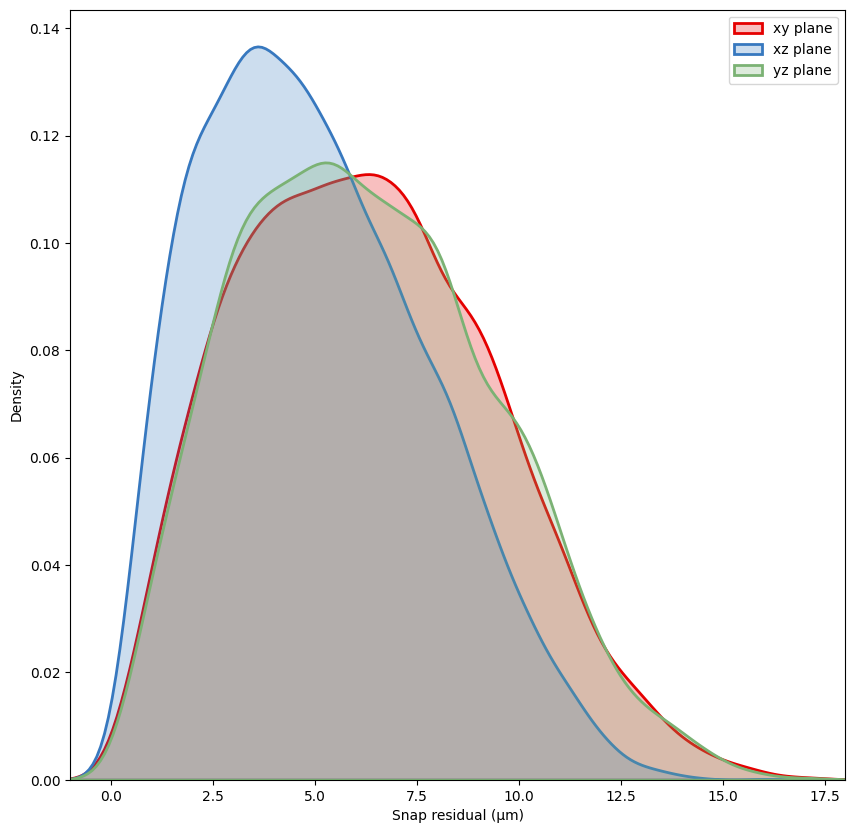

In [149]:
fig, ax = plt.subplots(figsize=(10,10))
axes_labels = ['x','y','z']
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    d_ = np.linalg.norm(snap_residuals[:, xy], axis=1)
    sns.kdeplot(d_/scalar,fill=True,linewidth=2,color=cc[ii+1],label=f'{axes_labels[_xaxis]}{axes_labels[_yaxis]} plane')
    # sns.histplot(d_/scalar,kde=True,color=cc[ii+1],stat='density',label=f'{axes_labels[_xaxis]}{axes_labels[_yaxis]} plane',line_kws={'linewidth':2})
ax.set_xlim([-1,18])
ax.set_xlabel('Snap residual (\u03BCm)')
ax.legend()
plt.savefig(os.path.join(PlotDir,f'snap-residuals_histogram_plane-comparison.png'))


## Lumping coregistration set with test set

In [102]:
#First let's lump together co-registered training set with the test set to get more points used to create the transform
test_set_em_coreg_pts = np.stack(test_set_df['em_final_em_nm'])/1000

#Get test set indices
test_set_idxs = get_array_subset_indices(all_roi_names, test_set_names)

#Transform test points from raw pixel space to coregistration space
test_centers_func_raw = all_roi_raw_center_pts[test_set_idxs]
test_set_func_coreg_pts = transform_pts(func_raw2coreg_tform, test_centers_func_raw)

#Get z-depth of all cells in microns
all_roi_depths = np.array([depth_dict[(1,roi.volume,roi.plane_z + 1)] for roi in all_roi_info])
test_set_depths = all_roi_depths[test_set_idxs]



In [104]:
test_set_func_coreg_pts[:,2] = test_set_depths

In [105]:

em_coreg_pts_all = np.concatenate((em_coreg_pts,test_set_em_coreg_pts))
func_coreg_pts_all = np.concatenate((func_coreg_pts,test_set_func_coreg_pts))


Text(0.5, 0, '2p -> EM residuals (microns)')

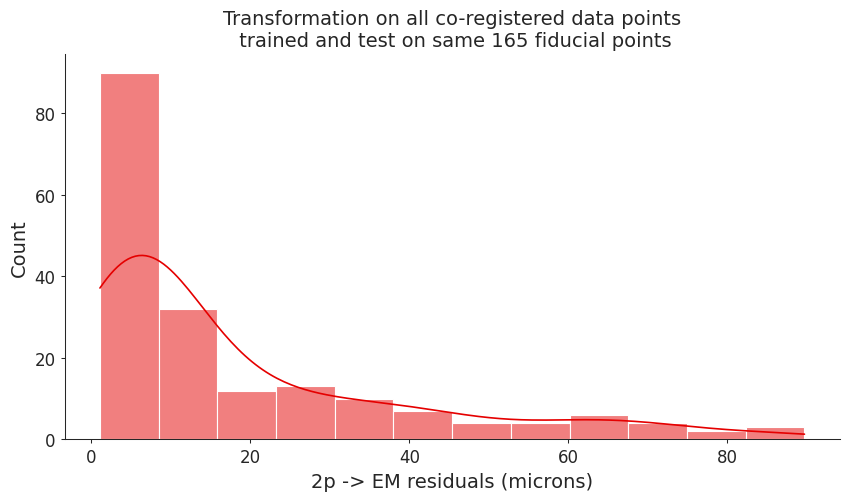

In [106]:
# estimate transformation
tform = coregister.transform.Transform(json=transform_obj)
tform.estimate(func_coreg_pts_all, em_coreg_pts_all)

fit_residuals = np.linalg.norm(tform.tform(func_coreg_pts_all)-em_coreg_pts_all, axis=1)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Transformation on all co-registered data points\n trained and test on same 165 fiducial points')
sns.histplot(fit_residuals,ax=ax,kde=True,color=cc[1])
ax.set_xlabel('2p -> EM residuals (microns)')
# plt.savefig(os.path.join(PlotDir,'residuals_fitonall.png'))

## Run Chase's basic affine transformation


Let P be the matrix of all 2P locations, with rows (2P x, 2P depth, 2P z). Similarly let C be the matrix of EM "cortical" locations with rows (EM x, EM depth, EM z).

We aim to find 3x3 matrix X that minimizes PX = C. The corresponding normal equation is P'PX = P'C.

We also add a bias term to offset

In [9]:
coreg = em_client.get_coregistration_table()
coreg.head()

# Load the corresponding 2P positions
coreg["ophys_pos"] = None

for idx, row in tqdm(coreg.iterrows(), total=len(coreg)):
    session = ophys_client.load_ophys_session(session_id=row.ophys_session_id)
    depth = session.get_plane_depth(plane=row.ophys_plane)
    y, x = np.mean(np.where(session.get_roi_image_mask(plane=row.ophys_plane, roi=row.ophys_roi)), axis=1) # note this is transposed
    coreg.at[idx, "ophys_pos"] = np.array([x, depth, y])

100%|██████████| 51/51 [00:00<00:00, 68.05it/s]


In [10]:
coreg_pts_microns = np.vstack(coreg.position_microns.values)
coreg_pts_ophys = np.vstack(coreg.ophys_pos.values)

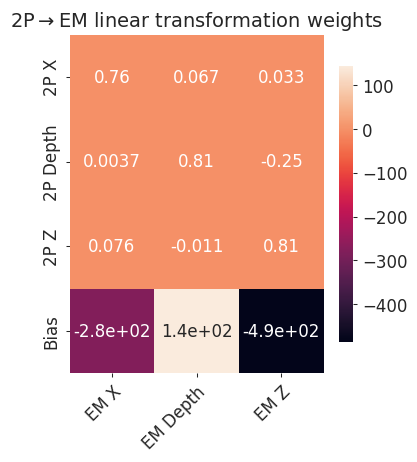

In [11]:
# P = coreg_pts_ophys
P = np.column_stack((coreg_pts_ophys, np.ones(len(coreg_pts_microns))))
C = coreg_pts_microns

# P = np.column_stack((func_coreg_pts, np.ones(len(em_coreg_pts))))
# C = em_coreg_pts
Pt = np.transpose(P)
X = np.linalg.solve(np.matmul(Pt, P), np.matmul(Pt, C))

fig, ax = plt.subplots(figsize=(4, 6))

sns.heatmap(X,annot=True,square=True,cbar_kws={'shrink':0.5})


row_labels = ["2P X", "2P Depth", "2P Z", "Bias"]
col_labels = ["EM X", "EM Depth", "EM Z"]

ax.set_xticks(np.arange(len(col_labels))+0.5, labels=col_labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(np.arange(len(row_labels))+0.5, labels=row_labels)

ax.set_title("2P$\\rightarrow$EM linear transformation weights")
fig.tight_layout()

Text(0, 0.5, 'ROI count')

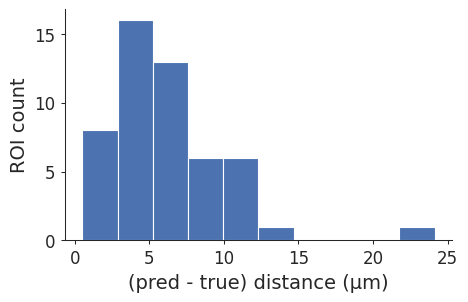

In [12]:
# Compute distance errors in microns
delta_microns = []
for i in range(len(coreg)):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns.append(np.linalg.norm(ci_true - ci_pred))

plt.figure(figsize=(5, 3))
plt.hist(delta_microns)
plt.xlabel("(pred - true) distance (µm)")
plt.ylabel("ROI count")

In [14]:
test_set_depths = all_roi_depths[test_set_idxs]

#Transform test points from raw pixel space to coregistration space
test_centers_func_raw = all_roi_raw_center_pts[test_set_idxs]
test_set_func_coreg_pts = transform_pts(func_raw2coreg_tform, test_centers_func_raw)
# test_set_func_coreg_pts[:,2] = test_set_depths

P = np.column_stack((test_set_func_coreg_pts, np.ones(len(test_set_func_coreg_pts))))

delta_microns_test = []
for i in range(len(test_set_func_coreg_pts)):
    pi = P[i]
    ci_pred = pi.dot(X)
    ci_true = test_set_em_final_pts_nms[i]/1000
    delta_microns_test.append(np.linalg.norm(ci_true - ci_pred))
    
plt.figure(figsize=(5, 3))
plt.hist(delta_microns_test)
plt.xlabel("(pred - true) distance (µm)")
plt.ylabel("ROI count")

NameError: name 'all_roi_depths' is not defined

## L1O Analysis on all co-registered cells

In [127]:
# evaluate l1out residual for all points
# TODO make helper method in coregister

# build leave-one-out dataset
@dataclasses.dataclass
class L1OutResult:
    src_pt : np.ndarray
    dst_pt : np.ndarray
    predicted_dst : np.ndarray
    pt_idx : str


l1out_transform_obj = {
        "name": "TransformList",
        "transforms": transform_list[:]
    }

src_vol_label = "opt"
dst_vol_label = "em"
l1out_src_pts = func_coreg_pts[:]
l1out_dst_pts = em_coreg_pts[:]

results = []
mean_residuals = []


In [128]:
#Get all cells in EM volume within bounding region
res = cave_client.materialize.query_table(
    "nucleus_detection_v0",filter_spatial_dict={"pt_position": query_bbox})

#Extract point position 
nucleus_pts = np.array([i for i in res.pt_position])
nucleus_ids = np.array([i for i in res.pt_root_id])
print(nucleus_pts.shape)

(21515, 3)


In [ ]:

#Loop over each cell and calculate tranform without it
for idx in range(l1out_src_pts.shape[0]):
    pts_mask = np.zeros(l1out_src_pts.shape[0], dtype=bool)
    pts_mask[idx] = True
    
    masked_src_pts = l1out_src_pts[~pts_mask]
    masked_dst_pts = l1out_dst_pts[~pts_mask]
    
    l1out_tform = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform.estimate(masked_src_pts, masked_dst_pts)
    
    mean_residuals.append(np.linalg.norm(tform.tform(masked_src_pts) - masked_dst_pts, axis=1).mean())
    
    lno_src_pts = np.array([l1out_src_pts[idx]])
    lno_dst_pts = np.array([l1out_dst_pts[idx]])
    
    predicted_dsts = l1out_tform.tform(lno_src_pts)
    
    #Find 1st and 2nd closest cells in the EM volume

    results.append(L1OutResult(
        src_pt=lno_src_pts[0], 
        dst_pt=lno_dst_pts[0],
        predicted_dst=predicted_dsts[0],
        pt_idx=idx
    ))

    




In [ ]:


nNeurons = all_roi_em_final_pts_nms.shape[0]

# match using 2d refinement
refinement_cutoff_nm = 6000
refinement_cutoff_rod = 0.75    #ratio between the closest and second closet em object
k=2
axes_2d = [0, 2]

#Define KD-tree based on em data
kdt = scipy.spatial.KDTree(nucleus_pts)

#Query the first and second nearest EM neighbours of the 2p data
distances, indices = kdt.query(all_roi_em_final_pts_nms, k=k)
rod = distances[:, 0] / distances[:, 1]

#Identify transformed 2p locations that are greater than 6microns to the nearest EM centroid AND has 2nd EM centroid that is >=8mm away 
refine_mask = (distances[:, 0] >= refinement_cutoff_nm) & (rod >= refinement_cutoff_rod)
print(f'{np.sum(refine_mask)}/{nNeurons} neurons are greater than {refinement_cutoff_nm/1000} microns from an EM centroid and have a cell distance ratio greater than {refinement_cutoff_rod}')

#Get nucleus centroids from EM data 
predicted_nucleus_pts_centroids = nucleus_pts[indices[:, 0]]

nSwap = 0
#Loop over each cell and create unique KD tree based on 2 closest neurons
for idx in np.argwhere(refine_mask):
    #Create tree based only on x and z dimensions in EM 
    kdt_2d = scipy.spatial.KDTree(nucleus_pts[indices[idx]][0, :, axes_2d].T)
    
    #Get 2D xz distance
    dists_2d, idxs_2d = kdt_2d.query([all_roi_em_final_pts_nms[idx, axes_2d]])

    #Choose closest neuron based on xz distance
    nucleus_idx = indices[idx][0][idxs_2d[0]]

    if idxs_2d[0] ==  1:
        nSwap += 1

    #Update
    predicted_nucleus_pts_centroids[idx] = nucleus_pts[nucleus_idx]

print(f'{nSwap}/{np.sum(refine_mask)} of these, we chose the 2nd closest cell')

In [ ]:
# Get 2p ROI center of mass 
all_roi_raw_center_pts = np.array([center_from_pix_mask(roi.pix_mask).tolist() + [roi.plane_z] for roi in all_roi_info])

# Get names
all_roi_names = np.array([roi.name for roi in all_roi_info])

#Get pika scores
pika_threshold = 0.5
all_pika_scores = np.array([roi.pika_score for roi in all_roi_info])
all_valid_cells = all_pika_scores > pika_threshold

# Transform raw 2p coordinates into co-registration space (micron space)
all_roi_func_coreg_pts = transform_pts(func_raw2coreg_tform, all_roi_raw_center_pts)

#Transform 2p functional locations to EM using transform created using all co-registered cells
all_roi_em_coreg_pts = tform.tform(all_roi_func_coreg_pts)

# Transform coregistered points back into EM space 
all_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, all_roi_em_coreg_pts)
all_roi_em_final_pts_nms = all_roi_em_final_pts_voxels * em_final_voxel_size

# Get co-registered test set
test_set_names = np.array([*test_set_name_to_final_em_nm.keys()])
test_set_em_final_pts_nms = np.array([*test_set_name_to_final_em_nm.values()])

# TODO implement this as a utility
def get_array_subset_indices(set_arr, subset_arr):
    set_arr_sorted = np.argsort(set_arr)
    subset_arr_pos = np.searchsorted(set_arr[set_arr_sorted], subset_arr)
    indices = set_arr_sorted[subset_arr_pos]
    return indices

#Get test set indices
test_set_idxs = get_array_subset_indices(all_roi_names, test_set_names)

#Transform test points from coregistration space to raw pixel space
test_centers_func_raw = all_roi_raw_center_pts[test_set_idxs]
corr_pts_func_raw = transform_pts(func_coreg2raw_tform, func_coreg_pts)

#Grab test set in em space
test_centers_em_nm = all_roi_em_final_pts_nms[test_set_idxs]

#Transform points used for creating transform into em space
corr_pts_em_voxels = transform_pts(em_coreg2final_tform, em_coreg_pts)
corr_pts_em_nm = corr_pts_em_voxels * em_final_voxel_size

#Get residuals on test cells
disps = test_centers_em_nm - test_set_em_final_pts_nms
test_set_residuals = np.linalg.norm(disps, axis=1)
print(np.mean(np.abs(disps), axis=0)/1000, 'microns')

In [ ]:
# evaluate l1out residual for all points
# TODO make helper method in coregister

# build leave-one-out dataset
@dataclasses.dataclass
class L1OutResult:
    src_pt : np.ndarray
    dst_pt : np.ndarray
    predicted_dst : np.ndarray
    pt_idx : str


l1out_transform_obj = {
        "name": "TransformList",
        "transforms": transform_list[:]
    }

src_vol_label = "opt"
dst_vol_label = "em"
l1out_src_pts = func_coreg_pts[:]
l1out_dst_pts = em_coreg_pts[:]

results = []
mean_residuals = []

#Loop over each cell and calculate tranform without it
for idx in range(l1out_src_pts.shape[0]):
    pts_mask = np.zeros(l1out_src_pts.shape[0], dtype=bool)
    pts_mask[idx] = True
    
    masked_src_pts = l1out_src_pts[~pts_mask]
    masked_dst_pts = l1out_dst_pts[~pts_mask]
    
    l1out_tform = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform.estimate(masked_src_pts, masked_dst_pts)
    
    mean_residuals.append(np.linalg.norm(tform.tform(masked_src_pts) - masked_dst_pts, axis=1).mean())
    
    
    lno_src_pts = np.array([l1out_src_pts[idx]])
    lno_dst_pts = np.array([l1out_dst_pts[idx]])
    
    predicted_dsts = l1out_tform.tform(lno_src_pts)
    
    results.append(L1OutResult(
        src_pt=lno_src_pts[0], 
        dst_pt=lno_dst_pts[0],
        predicted_dst=predicted_dsts[0],
        pt_idx=idx
    ))


l1out_disps = np.array([r.dst_pt - r.predicted_dst for r in results])
l1out_residuals = np.linalg.norm(l1out_disps, axis=1)